In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, Dropout, Flatten, Dense
from keras.layers import GlobalMaxPooling2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_FILE = 'data/train_data.h5'
METADATA = 'metadata.npy'

f = h5py.File(DATA_FILE, 'r')
data_x = f['x']
data_y = f['y']
metadata = np.load(METADATA).item()

In [3]:
from sklearn.model_selection import train_test_split

data_x = np.asarray(data_x)
data_y = np.asarray(data_y)
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.15, random_state=42)

In [4]:
import pandas as pd

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [5]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    recall = recall(y_true, y_pred)
    precision = precision(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [6]:
lr = 1e-3
n_conv_layers = 3
n_kernels = [128] * n_conv_layers
mp_sizes = [(2,2) for _ in range(n_conv_layers)]
dropout_values = [0.25] * n_conv_layers

model = Sequential()
model.add(BatchNormalization(axis=3, input_shape=data_x.shape[1:]))
for i in range(n_conv_layers):
    model.add(Conv2D(n_kernels[i], (3, 3), padding="same", kernel_initializer="he_uniform"))
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    if i < n_conv_layers - 1:
        model.add(Dropout(dropout_values[i]))

model.add(Conv2D(12, (3, 3), padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Activation('softmax'))
model.compile(Adam(lr), loss='categorical_crossentropy', metrics=['accuracy', recall, precision, f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 1, 1, 2048)        8192      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 128)         2359424   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 1, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 128)         147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 1, 128)         512       
__________

In [7]:
model_filepath = 'models/CNN_Model.h5'
callbacks = [ModelCheckpoint(model_filepath, monitor='f1', verbose=0, save_best_only=True, mode="max")]
model.fit(X_train, y_train, batch_size=64, epochs=15,
          validation_data=(X_val, y_val), callbacks=callbacks)

Train on 4037 samples, validate on 713 samples
Epoch 1/15


  64/4037 [..............................] - ETA: 84s - loss: 2.5413 - acc: 0.0312 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: nan

 128/4037 [..............................] - ETA: 50s - loss: 2.5027 - acc: 0.1016 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: nan

 192/4037 [>.............................] - ETA: 39s - loss: 2.4646 - acc: 0.1198 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: nan

 256/4037 [>.............................] - ETA: 33s - loss: 2.4305 - acc: 0.1484 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: nan

 320/4037 [=>............................] - ETA: 29s - loss: 2.4069 - acc: 0.1812 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: nan

 384/4037 [=>............................] - ETA: 27s - loss: 2.3670 - acc: 0.2188 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: nan

 448/4037 [==>...........................] - ETA: 25s - loss: 2.3419 - acc: 0.2277 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: nan

 512/4037 [==>...........................] - ETA: 24s - loss: 2.3179 - acc: 0.2441 - recall: 0.0020 - precision: 0.1250 - f1: nan        

 576/4037 [===>..........................] - ETA: 22s - loss: 2.2847 - acc: 0.2639 - recall: 0.0017 - precision: 0.1111 - f1: nan

 640/4037 [===>..........................] - ETA: 21s - loss: 2.2521 - acc: 0.2828 - recall: 0.0016 - precision: 0.1000 - f1: nan

 704/4037 [====>.........................] - ETA: 20s - loss: 2.2259 - acc: 0.3026 - recall: 0.0043 - precision: 0.1818 - f1: nan

 768/4037 [====>.........................] - ETA: 20s - loss: 2.2059 - acc: 0.3060 - recall: 0.0052 - precision: 0.2500 - f1: nan

 832/4037 [=====>........................] - ETA: 19s - loss: 2.1867 - acc: 0.3221 - recall: 0.0060 - precision: 0.3077 - f1: nan

 896/4037 [=====>........................] - ETA: 18s - loss: 2.1744 - acc: 0.3203 - recall: 0.0078 - precision: 0.3333 - f1: nan

 960/4037 [======>.......................] - ETA: 17s - loss: 2.1542 - acc: 0.3292 - recall: 0.0083 - precision: 0.3778 - f1: nan

1024/4037 [======>.......................] - ETA: 17s - loss: 2.1358 - acc: 0.3379 - recall: 0.0127 - precision: 0.4167 - f1: nan

1088/4037 [=======>......................] - ETA: 16s - loss: 2.1090 - acc: 0.3483 - recall: 0.0165 - precision: 0.4342 - f1: nan

1152/4037 [=======>......................] - ETA: 16s - loss: 2.0869 - acc: 0.3594 - recall: 0.0191 - precision: 0.4656 - f1: nan

1216/4037 [========>.....................] - ETA: 15s - loss: 2.0729 - acc: 0.3627 - recall: 0.0230 - precision: 0.4862 - f1: nan

1280/4037 [========>.....................] - ETA: 15s - loss: 2.0476 - acc: 0.3773 - recall: 0.0273 - precision: 0.5119 - f1: nan

1344/4037 [========>.....................] - ETA: 14s - loss: 2.0261 - acc: 0.3876 - recall: 0.0298 - precision: 0.5215 - f1: nan

1408/4037 [=========>....................] - ETA: 14s - loss: 2.0141 - acc: 0.3942 - recall: 0.0320 - precision: 0.5357 - f1: nan

1472/4037 [=========>....................] - ETA: 13s - loss: 1.9915 - acc: 0.4035 - recall: 0.0367 - precision: 0.5559 - f1: nan

1536/4037 [==========>...................] - ETA: 13s - loss: 1.9802 - acc: 0.4095 - recall: 0.0391 - precision: 0.5640 - f1: nan

1600/4037 [==========>...................] - ETA: 13s - loss: 1.9616 - acc: 0.4156 - recall: 0.0444 - precision: 0.5814 - f1: nan

1664/4037 [===========>..................] - ETA: 13s - loss: 1.9418 - acc: 0.4231 - recall: 0.0505 - precision: 0.5948 - f1: nan

1728/4037 [===========>..................] - ETA: 13s - loss: 1.9242 - acc: 0.4306 - recall: 0.0544 - precision: 0.6036 - f1: nan

1792/4037 [============>.................] - ETA: 13s - loss: 1.9049 - acc: 0.4375 - recall: 0.0586 - precision: 0.6082 - f1: nan

1856/4037 [============>.................] - ETA: 13s - loss: 1.8868 - acc: 0.4445 - recall: 0.0641 - precision: 0.6195 - f1: nan

1920/4037 [=============>................] - ETA: 12s - loss: 1.8666 - acc: 0.4542 - recall: 0.0688 - precision: 0.6259 - f1: nan

1984/4037 [=============>................] - ETA: 12s - loss: 1.8480 - acc: 0.4627 - recall: 0.0721 - precision: 0.6294 - f1: nan

2048/4037 [==============>...............] - ETA: 11s - loss: 1.8360 - acc: 0.4668 - recall: 0.0762 - precision: 0.6323 - f1: nan

2112/4037 [==============>...............] - ETA: 11s - loss: 1.8193 - acc: 0.4725 - recall: 0.0814 - precision: 0.6400 - f1: nan

2176/4037 [===============>..............] - ETA: 11s - loss: 1.8022 - acc: 0.4779 - recall: 0.0850 - precision: 0.6467 - f1: nan

2240/4037 [===============>..............] - ETA: 10s - loss: 1.7905 - acc: 0.4826 - recall: 0.0884 - precision: 0.6478 - f1: nan

2304/4037 [================>.............] - ETA: 10s - loss: 1.7742 - acc: 0.4857 - recall: 0.0942 - precision: 0.6527 - f1: nan

2368/4037 [================>.............] - ETA: 9s - loss: 1.7637 - acc: 0.4882 - recall: 0.0976 - precision: 0.6561 - f1: nan 

2432/4037 [=================>............] - ETA: 9s - loss: 1.7481 - acc: 0.4930 - recall: 0.1040 - precision: 0.6630 - f1: nan

2496/4037 [=================>............] - ETA: 9s - loss: 1.7334 - acc: 0.4976 - recall: 0.1102 - precision: 0.6685 - f1: nan

2560/4037 [==================>...........] - ETA: 8s - loss: 1.7182 - acc: 0.5043 - recall: 0.1176 - precision: 0.6768 - f1: nan

2624/4037 [==================>...........] - ETA: 8s - loss: 1.7059 - acc: 0.5080 - recall: 0.1220 - precision: 0.6814 - f1: nan

2688/4037 [==================>...........] - ETA: 8s - loss: 1.6942 - acc: 0.5115 - recall: 0.1276 - precision: 0.6847 - f1: nan

2752/4037 [===================>..........] - ETA: 8s - loss: 1.6821 - acc: 0.5160 - recall: 0.1323 - precision: 0.6891 - f1: nan

2816/4037 [===================>..........] - ETA: 8s - loss: 1.6714 - acc: 0.5192 - recall: 0.1364 - precision: 0.6924 - f1: nan

2880/4037 [====================>.........] - ETA: 7s - loss: 1.6552 - acc: 0.5257 - recall: 0.1427 - precision: 0.6985 - f1: nan

2944/4037 [====================>.........] - ETA: 7s - loss: 1.6445 - acc: 0.5306 - recall: 0.1467 - precision: 0.7031 - f1: nan

3008/4037 [=====================>........] - ETA: 6s - loss: 1.6321 - acc: 0.5342 - recall: 0.1533 - precision: 0.7081 - f1: nan

3072/4037 [=====================>........] - ETA: 6s - loss: 1.6196 - acc: 0.5384 - recall: 0.1589 - precision: 0.7134 - f1: nan

3136/4037 [======================>.......] - ETA: 5s - loss: 1.6089 - acc: 0.5411 - recall: 0.1639 - precision: 0.7165 - f1: nan

3200/4037 [======================>.......] - ETA: 5s - loss: 1.6000 - acc: 0.5447 - recall: 0.1688 - precision: 0.7190 - f1: nan

3264/4037 [=======================>......] - ETA: 5s - loss: 1.5874 - acc: 0.5484 - recall: 0.1749 - precision: 0.7233 - f1: nan

3328/4037 [=======================>......] - ETA: 4s - loss: 1.5760 - acc: 0.5526 - recall: 0.1806 - precision: 0.7264 - f1: nan

3392/4037 [========================>.....] - ETA: 4s - loss: 1.5651 - acc: 0.5554 - recall: 0.1857 - precision: 0.7297 - f1: nan

3456/4037 [========================>.....] - ETA: 3s - loss: 1.5568 - acc: 0.5573 - recall: 0.1907 - precision: 0.7316 - f1: nan

3520/4037 [=========================>....] - ETA: 3s - loss: 1.5457 - acc: 0.5611 - recall: 0.1969 - precision: 0.7350 - f1: nan

3584/4037 [=========================>....] - ETA: 2s - loss: 1.5357 - acc: 0.5650 - recall: 0.2017 - precision: 0.7381 - f1: nan

3648/4037 [==========================>...] - ETA: 2s - loss: 1.5248 - acc: 0.5685 - recall: 0.2064 - precision: 0.7416 - f1: nan

3712/4037 [==========================>...] - ETA: 2s - loss: 1.5147 - acc: 0.5717 - recall: 0.2117 - precision: 0.7442 - f1: nan

3776/4037 [===========================>..] - ETA: 1s - loss: 1.5042 - acc: 0.5757 - recall: 0.2172 - precision: 0.7467 - f1: nan

3840/4037 [===========================>..] - ETA: 1s - loss: 1.4965 - acc: 0.5776 - recall: 0.2211 - precision: 0.7481 - f1: nan

3904/4037 [============================>.] - ETA: 0s - loss: 1.4858 - acc: 0.5812 - recall: 0.2262 - precision: 0.7505 - f1: nan

3968/4037 [============================>.] - ETA: 0s - loss: 1.4783 - acc: 0.5827 - recall: 0.2296 - precision: 0.7506 - f1: nan

4032/4037 [============================>.] - ETA: 0s - loss: 1.4677 - acc: 0.5858 - recall: 0.2356 - precision: 0.7534 - f1: nan

4037/4037 [==============================] - 26s - loss: 1.4679 - acc: 0.5856 - recall: 0.2358 - precision: 0.7533 - f1: nan - val_loss: 1.7359 - val_acc: 0.7279 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1: nan


Epoch 2/15


  64/4037 [..............................] - ETA: 17s - loss: 0.8060 - acc: 0.8125 - recall: 0.5156 - precision: 0.9167 - f1: 0.6600

 128/4037 [..............................] - ETA: 17s - loss: 0.7974 - acc: 0.7656 - recall: 0.5469 - precision: 0.8988 - f1: 0.6791

 192/4037 [>.............................] - ETA: 16s - loss: 0.7834 - acc: 0.7812 - recall: 0.5781 - precision: 0.9098 - f1: 0.7058

 256/4037 [>.............................] - ETA: 16s - loss: 0.8325 - acc: 0.7539 - recall: 0.5703 - precision: 0.9011 - f1: 0.6976

 320/4037 [=>............................] - ETA: 15s - loss: 0.8426 - acc: 0.7469 - recall: 0.5687 - precision: 0.9104 - f1: 0.6993

 384/4037 [=>............................] - ETA: 15s - loss: 0.8099 - acc: 0.7630 - recall: 0.5885 - precision: 0.9181 - f1: 0.7161

 448/4037 [==>...........................] - ETA: 15s - loss: 0.8069 - acc: 0.7612 - recall: 0.5893 - precision: 0.9162 - f1: 0.7162

 512/4037 [==>...........................] - ETA: 15s - loss: 0.8083 - acc: 0.7617 - recall: 0.5859 - precision: 0.9063 - f1: 0.7108

 576/4037 [===>..........................] - ETA: 14s - loss: 0.7929 - acc: 0.7691 - recall: 0.5885 - precision: 0.9139 - f1: 0.7151

 640/4037 [===>..........................] - ETA: 14s - loss: 0.7964 - acc: 0.7641 - recall: 0.5875 - precision: 0.9086 - f1: 0.7128

 704/4037 [====>.........................] - ETA: 14s - loss: 0.8004 - acc: 0.7628 - recall: 0.5810 - precision: 0.9071 - f1: 0.7074

 768/4037 [====>.........................] - ETA: 13s - loss: 0.7877 - acc: 0.7721 - recall: 0.5872 - precision: 0.9110 - f1: 0.7133

 832/4037 [=====>........................] - ETA: 13s - loss: 0.7910 - acc: 0.7692 - recall: 0.5841 - precision: 0.9100 - f1: 0.7107

 896/4037 [=====>........................] - ETA: 13s - loss: 0.7794 - acc: 0.7746 - recall: 0.5882 - precision: 0.9147 - f1: 0.7152

 960/4037 [======>.......................] - ETA: 13s - loss: 0.7668 - acc: 0.7812 - recall: 0.5938 - precision: 0.9134 - f1: 0.7187

1024/4037 [======>.......................] - ETA: 12s - loss: 0.7637 - acc: 0.7861 - recall: 0.5947 - precision: 0.9173 - f1: 0.7206

1088/4037 [=======>......................] - ETA: 12s - loss: 0.7579 - acc: 0.7877 - recall: 0.5974 - precision: 0.9169 - f1: 0.7225

1152/4037 [=======>......................] - ETA: 12s - loss: 0.7534 - acc: 0.7917 - recall: 0.6033 - precision: 0.9181 - f1: 0.7270

1216/4037 [========>.....................] - ETA: 12s - loss: 0.7452 - acc: 0.7936 - recall: 0.6102 - precision: 0.9202 - f1: 0.7325

1280/4037 [========>.....................] - ETA: 12s - loss: 0.7450 - acc: 0.7945 - recall: 0.6094 - precision: 0.9184 - f1: 0.7314

1344/4037 [========>.....................] - ETA: 11s - loss: 0.7409 - acc: 0.7954 - recall: 0.6094 - precision: 0.9159 - f1: 0.7307

1408/4037 [=========>....................] - ETA: 11s - loss: 0.7401 - acc: 0.7947 - recall: 0.6101 - precision: 0.9138 - f1: 0.7305

1472/4037 [=========>....................] - ETA: 11s - loss: 0.7355 - acc: 0.7962 - recall: 0.6141 - precision: 0.9132 - f1: 0.7331

1536/4037 [==========>...................] - ETA: 11s - loss: 0.7294 - acc: 0.7982 - recall: 0.6185 - precision: 0.9128 - f1: 0.7359

1600/4037 [==========>...................] - ETA: 11s - loss: 0.7263 - acc: 0.7994 - recall: 0.6219 - precision: 0.9146 - f1: 0.7389

1664/4037 [===========>..................] - ETA: 11s - loss: 0.7235 - acc: 0.7987 - recall: 0.6238 - precision: 0.9106 - f1: 0.7387

1728/4037 [===========>..................] - ETA: 10s - loss: 0.7193 - acc: 0.7986 - recall: 0.6244 - precision: 0.9078 - f1: 0.7382

1792/4037 [============>.................] - ETA: 10s - loss: 0.7158 - acc: 0.8008 - recall: 0.6272 - precision: 0.9076 - f1: 0.7401

1856/4037 [============>.................] - ETA: 10s - loss: 0.7103 - acc: 0.8017 - recall: 0.6304 - precision: 0.9108 - f1: 0.7434

1920/4037 [=============>................] - ETA: 10s - loss: 0.7069 - acc: 0.8016 - recall: 0.6333 - precision: 0.9105 - f1: 0.7453

1984/4037 [=============>................] - ETA: 10s - loss: 0.7026 - acc: 0.8039 - recall: 0.6356 - precision: 0.9107 - f1: 0.7469

2048/4037 [==============>...............] - ETA: 9s - loss: 0.7007 - acc: 0.8037 - recall: 0.6357 - precision: 0.9107 - f1: 0.7471 

2112/4037 [==============>...............] - ETA: 9s - loss: 0.6975 - acc: 0.8045 - recall: 0.6387 - precision: 0.9100 - f1: 0.7488

2176/4037 [===============>..............] - ETA: 9s - loss: 0.6953 - acc: 0.8051 - recall: 0.6406 - precision: 0.9120 - f1: 0.7508

2240/4037 [===============>..............] - ETA: 9s - loss: 0.6962 - acc: 0.8045 - recall: 0.6411 - precision: 0.9110 - f1: 0.7508

2304/4037 [================>.............] - ETA: 8s - loss: 0.6907 - acc: 0.8069 - recall: 0.6445 - precision: 0.9113 - f1: 0.7532

2368/4037 [================>.............] - ETA: 8s - loss: 0.6874 - acc: 0.8083 - recall: 0.6461 - precision: 0.9110 - f1: 0.7542

2432/4037 [=================>............] - ETA: 8s - loss: 0.6853 - acc: 0.8084 - recall: 0.6476 - precision: 0.9117 - f1: 0.7555

2496/4037 [=================>............] - ETA: 7s - loss: 0.6827 - acc: 0.8089 - recall: 0.6502 - precision: 0.9111 - f1: 0.7570

2560/4037 [==================>...........] - ETA: 7s - loss: 0.6780 - acc: 0.8109 - recall: 0.6523 - precision: 0.9123 - f1: 0.7589

2624/4037 [==================>...........] - ETA: 7s - loss: 0.6742 - acc: 0.8114 - recall: 0.6547 - precision: 0.9130 - f1: 0.7607

2688/4037 [==================>...........] - ETA: 6s - loss: 0.6719 - acc: 0.8118 - recall: 0.6570 - precision: 0.9133 - f1: 0.7623

2752/4037 [===================>..........] - ETA: 6s - loss: 0.6693 - acc: 0.8121 - recall: 0.6573 - precision: 0.9129 - f1: 0.7624

2816/4037 [===================>..........] - ETA: 6s - loss: 0.6659 - acc: 0.8132 - recall: 0.6594 - precision: 0.9139 - f1: 0.7642

2880/4037 [====================>.........] - ETA: 5s - loss: 0.6640 - acc: 0.8142 - recall: 0.6597 - precision: 0.9140 - f1: 0.7645

2944/4037 [====================>.........] - ETA: 5s - loss: 0.6596 - acc: 0.8159 - recall: 0.6627 - precision: 0.9143 - f1: 0.7665

3008/4037 [=====================>........] - ETA: 5s - loss: 0.6589 - acc: 0.8162 - recall: 0.6642 - precision: 0.9148 - f1: 0.7677

3072/4037 [=====================>........] - ETA: 4s - loss: 0.6579 - acc: 0.8158 - recall: 0.6654 - precision: 0.9138 - f1: 0.7681

3136/4037 [======================>.......] - ETA: 4s - loss: 0.6551 - acc: 0.8160 - recall: 0.6668 - precision: 0.9148 - f1: 0.7694

3200/4037 [======================>.......] - ETA: 4s - loss: 0.6556 - acc: 0.8153 - recall: 0.6659 - precision: 0.9131 - f1: 0.7683

3264/4037 [=======================>......] - ETA: 3s - loss: 0.6526 - acc: 0.8159 - recall: 0.6670 - precision: 0.9140 - f1: 0.7694

3328/4037 [=======================>......] - ETA: 3s - loss: 0.6526 - acc: 0.8158 - recall: 0.6674 - precision: 0.9137 - f1: 0.7695

3392/4037 [========================>.....] - ETA: 3s - loss: 0.6513 - acc: 0.8163 - recall: 0.6683 - precision: 0.9128 - f1: 0.7698

3456/4037 [========================>.....] - ETA: 2s - loss: 0.6466 - acc: 0.8174 - recall: 0.6707 - precision: 0.9131 - f1: 0.7715

3520/4037 [=========================>....] - ETA: 2s - loss: 0.6425 - acc: 0.8187 - recall: 0.6730 - precision: 0.9140 - f1: 0.7733

3584/4037 [=========================>....] - ETA: 2s - loss: 0.6395 - acc: 0.8192 - recall: 0.6758 - precision: 0.9140 - f1: 0.7750

3648/4037 [==========================>...] - ETA: 1s - loss: 0.6380 - acc: 0.8185 - recall: 0.6771 - precision: 0.9133 - f1: 0.7756

3712/4037 [==========================>...] - ETA: 1s - loss: 0.6348 - acc: 0.8195 - recall: 0.6797 - precision: 0.9136 - f1: 0.7773

3776/4037 [===========================>..] - ETA: 1s - loss: 0.6327 - acc: 0.8207 - recall: 0.6809 - precision: 0.9137 - f1: 0.7781

3840/4037 [===========================>..] - ETA: 1s - loss: 0.6307 - acc: 0.8208 - recall: 0.6826 - precision: 0.9134 - f1: 0.7791

3904/4037 [============================>.] - ETA: 0s - loss: 0.6282 - acc: 0.8217 - recall: 0.6842 - precision: 0.9139 - f1: 0.7803

3968/4037 [============================>.] - ETA: 0s - loss: 0.6252 - acc: 0.8226 - recall: 0.6865 - precision: 0.9139 - f1: 0.7817

4032/4037 [============================>.] - ETA: 0s - loss: 0.6203 - acc: 0.8242 - recall: 0.6880 - precision: 0.9141 - f1: 0.7828

4037/4037 [==============================] - 21s - loss: 0.6207 - acc: 0.8241 - recall: 0.6879 - precision: 0.9138 - f1: 0.7826 - val_loss: 0.8813 - val_acc: 0.8569 - val_recall: 0.4418 - val_precision: 0.9801 - val_f1: 0.6060


Epoch 3/15


  64/4037 [..............................] - ETA: 19s - loss: 0.3501 - acc: 0.9375 - recall: 0.7812 - precision: 0.9615 - f1: 0.8621

 128/4037 [..............................] - ETA: 18s - loss: 0.4112 - acc: 0.8984 - recall: 0.7500 - precision: 0.9408 - f1: 0.8345

 192/4037 [>.............................] - ETA: 18s - loss: 0.4043 - acc: 0.9010 - recall: 0.7760 - precision: 0.9427 - f1: 0.8508

 256/4037 [>.............................] - ETA: 18s - loss: 0.4061 - acc: 0.8945 - recall: 0.7852 - precision: 0.9391 - f1: 0.8548

 320/4037 [=>............................] - ETA: 18s - loss: 0.3978 - acc: 0.8969 - recall: 0.8000 - precision: 0.9377 - f1: 0.8627

 384/4037 [=>............................] - ETA: 17s - loss: 0.4025 - acc: 0.8906 - recall: 0.7995 - precision: 0.9306 - f1: 0.8594

 448/4037 [==>...........................] - ETA: 17s - loss: 0.4199 - acc: 0.8862 - recall: 0.7969 - precision: 0.9230 - f1: 0.8547

 512/4037 [==>...........................] - ETA: 17s - loss: 0.4357 - acc: 0.8789 - recall: 0.7930 - precision: 0.9170 - f1: 0.8499

 576/4037 [===>..........................] - ETA: 16s - loss: 0.4433 - acc: 0.8767 - recall: 0.7934 - precision: 0.9145 - f1: 0.8492

 640/4037 [===>..........................] - ETA: 16s - loss: 0.4351 - acc: 0.8797 - recall: 0.8000 - precision: 0.9132 - f1: 0.8522

 704/4037 [====>.........................] - ETA: 16s - loss: 0.4310 - acc: 0.8835 - recall: 0.7997 - precision: 0.9177 - f1: 0.8540

 768/4037 [====>.........................] - ETA: 16s - loss: 0.4484 - acc: 0.8737 - recall: 0.7891 - precision: 0.9174 - f1: 0.8474

 832/4037 [=====>........................] - ETA: 16s - loss: 0.4477 - acc: 0.8726 - recall: 0.7885 - precision: 0.9155 - f1: 0.8463

 896/4037 [=====>........................] - ETA: 16s - loss: 0.4510 - acc: 0.8717 - recall: 0.7868 - precision: 0.9126 - f1: 0.8442

 960/4037 [======>.......................] - ETA: 16s - loss: 0.4504 - acc: 0.8698 - recall: 0.7885 - precision: 0.9116 - f1: 0.8448

1024/4037 [======>.......................] - ETA: 16s - loss: 0.4450 - acc: 0.8740 - recall: 0.7930 - precision: 0.9129 - f1: 0.8479

1088/4037 [=======>......................] - ETA: 15s - loss: 0.4466 - acc: 0.8713 - recall: 0.7932 - precision: 0.9147 - f1: 0.8488

1152/4037 [=======>......................] - ETA: 15s - loss: 0.4442 - acc: 0.8707 - recall: 0.7934 - precision: 0.9145 - f1: 0.8489

1216/4037 [========>.....................] - ETA: 15s - loss: 0.4370 - acc: 0.8734 - recall: 0.7961 - precision: 0.9145 - f1: 0.8504

1280/4037 [========>.....................] - ETA: 15s - loss: 0.4421 - acc: 0.8711 - recall: 0.7937 - precision: 0.9141 - f1: 0.8489

1344/4037 [========>.....................] - ETA: 15s - loss: 0.4458 - acc: 0.8690 - recall: 0.7917 - precision: 0.9114 - f1: 0.8466

1408/4037 [=========>....................] - ETA: 15s - loss: 0.4473 - acc: 0.8707 - recall: 0.7912 - precision: 0.9137 - f1: 0.8473

1472/4037 [=========>....................] - ETA: 16s - loss: 0.4471 - acc: 0.8689 - recall: 0.7914 - precision: 0.9150 - f1: 0.8481

1536/4037 [==========>...................] - ETA: 15s - loss: 0.4426 - acc: 0.8704 - recall: 0.7956 - precision: 0.9152 - f1: 0.8504

1600/4037 [==========>...................] - ETA: 15s - loss: 0.4428 - acc: 0.8688 - recall: 0.7950 - precision: 0.9125 - f1: 0.8489

1664/4037 [===========>..................] - ETA: 14s - loss: 0.4374 - acc: 0.8696 - recall: 0.7987 - precision: 0.9139 - f1: 0.8516

1728/4037 [===========>..................] - ETA: 14s - loss: 0.4369 - acc: 0.8692 - recall: 0.7992 - precision: 0.9139 - f1: 0.8519

1792/4037 [============>.................] - ETA: 14s - loss: 0.4366 - acc: 0.8705 - recall: 0.8008 - precision: 0.9145 - f1: 0.8531

1856/4037 [============>.................] - ETA: 13s - loss: 0.4342 - acc: 0.8712 - recall: 0.8006 - precision: 0.9143 - f1: 0.8530

1920/4037 [=============>................] - ETA: 13s - loss: 0.4329 - acc: 0.8724 - recall: 0.8021 - precision: 0.9139 - f1: 0.8536

1984/4037 [=============>................] - ETA: 12s - loss: 0.4269 - acc: 0.8755 - recall: 0.8054 - precision: 0.9166 - f1: 0.8567

2048/4037 [==============>...............] - ETA: 12s - loss: 0.4311 - acc: 0.8745 - recall: 0.8032 - precision: 0.9162 - f1: 0.8553

2112/4037 [==============>...............] - ETA: 12s - loss: 0.4340 - acc: 0.8717 - recall: 0.8016 - precision: 0.9140 - f1: 0.8534

2176/4037 [===============>..............] - ETA: 11s - loss: 0.4323 - acc: 0.8718 - recall: 0.8024 - precision: 0.9140 - f1: 0.8539

2240/4037 [===============>..............] - ETA: 11s - loss: 0.4341 - acc: 0.8701 - recall: 0.8004 - precision: 0.9137 - f1: 0.8526

2304/4037 [================>.............] - ETA: 11s - loss: 0.4372 - acc: 0.8681 - recall: 0.7969 - precision: 0.9117 - f1: 0.8497

2368/4037 [================>.............] - ETA: 12s - loss: 0.4348 - acc: 0.8691 - recall: 0.7986 - precision: 0.9119 - f1: 0.8507

2432/4037 [=================>............] - ETA: 12s - loss: 0.4334 - acc: 0.8697 - recall: 0.7981 - precision: 0.9127 - f1: 0.8508

2496/4037 [=================>............] - ETA: 11s - loss: 0.4293 - acc: 0.8714 - recall: 0.8013 - precision: 0.9145 - f1: 0.8534

2560/4037 [==================>...........] - ETA: 11s - loss: 0.4250 - acc: 0.8730 - recall: 0.8039 - precision: 0.9162 - f1: 0.8557

2624/4037 [==================>...........] - ETA: 10s - loss: 0.4241 - acc: 0.8731 - recall: 0.8034 - precision: 0.9161 - f1: 0.8553

2688/4037 [==================>...........] - ETA: 10s - loss: 0.4233 - acc: 0.8735 - recall: 0.8032 - precision: 0.9172 - f1: 0.8557

2752/4037 [===================>..........] - ETA: 9s - loss: 0.4204 - acc: 0.8743 - recall: 0.8056 - precision: 0.9176 - f1: 0.8572 

2816/4037 [===================>..........] - ETA: 9s - loss: 0.4176 - acc: 0.8757 - recall: 0.8072 - precision: 0.9183 - f1: 0.8584

2880/4037 [====================>.........] - ETA: 8s - loss: 0.4154 - acc: 0.8767 - recall: 0.8087 - precision: 0.9186 - f1: 0.8594

2944/4037 [====================>.........] - ETA: 8s - loss: 0.4150 - acc: 0.8767 - recall: 0.8094 - precision: 0.9186 - f1: 0.8598

3008/4037 [=====================>........] - ETA: 7s - loss: 0.4143 - acc: 0.8767 - recall: 0.8092 - precision: 0.9184 - f1: 0.8596

3072/4037 [=====================>........] - ETA: 6s - loss: 0.4139 - acc: 0.8773 - recall: 0.8099 - precision: 0.9187 - f1: 0.8601

3136/4037 [======================>.......] - ETA: 6s - loss: 0.4132 - acc: 0.8779 - recall: 0.8112 - precision: 0.9196 - f1: 0.8613

3200/4037 [======================>.......] - ETA: 5s - loss: 0.4106 - acc: 0.8784 - recall: 0.8131 - precision: 0.9196 - f1: 0.8623

3264/4037 [=======================>......] - ETA: 5s - loss: 0.4099 - acc: 0.8787 - recall: 0.8146 - precision: 0.9199 - f1: 0.8633

3328/4037 [=======================>......] - ETA: 5s - loss: 0.4070 - acc: 0.8798 - recall: 0.8164 - precision: 0.9205 - f1: 0.8646

3392/4037 [========================>.....] - ETA: 4s - loss: 0.4042 - acc: 0.8800 - recall: 0.8178 - precision: 0.9202 - f1: 0.8652

3456/4037 [========================>.....] - ETA: 4s - loss: 0.4056 - acc: 0.8793 - recall: 0.8180 - precision: 0.9195 - f1: 0.8650

3520/4037 [=========================>....] - ETA: 3s - loss: 0.4046 - acc: 0.8790 - recall: 0.8182 - precision: 0.9191 - f1: 0.8649

3584/4037 [=========================>....] - ETA: 3s - loss: 0.4036 - acc: 0.8792 - recall: 0.8181 - precision: 0.9193 - f1: 0.8650

3648/4037 [==========================>...] - ETA: 2s - loss: 0.4037 - acc: 0.8788 - recall: 0.8169 - precision: 0.9185 - f1: 0.8639

3712/4037 [==========================>...] - ETA: 2s - loss: 0.4034 - acc: 0.8782 - recall: 0.8168 - precision: 0.9181 - f1: 0.8638

3776/4037 [===========================>..] - ETA: 1s - loss: 0.4024 - acc: 0.8787 - recall: 0.8175 - precision: 0.9186 - f1: 0.8644

3840/4037 [===========================>..] - ETA: 1s - loss: 0.4042 - acc: 0.8776 - recall: 0.8174 - precision: 0.9173 - f1: 0.8637

3904/4037 [============================>.] - ETA: 0s - loss: 0.4041 - acc: 0.8770 - recall: 0.8176 - precision: 0.9167 - f1: 0.8636

3968/4037 [============================>.] - ETA: 0s - loss: 0.4041 - acc: 0.8773 - recall: 0.8185 - precision: 0.9168 - f1: 0.8641

4032/4037 [============================>.] - ETA: 0s - loss: 0.4038 - acc: 0.8777 - recall: 0.8182 - precision: 0.9169 - f1: 0.8640

4037/4037 [==============================] - 27s - loss: 0.4056 - acc: 0.8771 - recall: 0.8177 - precision: 0.9164 - f1: 0.8635 - val_loss: 0.4745 - val_acc: 0.8640 - val_recall: 0.7784 - val_precision: 0.9389 - val_f1: 0.8509


Epoch 4/15


  64/4037 [..............................] - ETA: 22s - loss: 0.4573 - acc: 0.8750 - recall: 0.7969 - precision: 0.8793 - f1: 0.8361

 128/4037 [..............................] - ETA: 21s - loss: 0.3864 - acc: 0.8828 - recall: 0.8359 - precision: 0.9224 - f1: 0.8770

 192/4037 [>.............................] - ETA: 20s - loss: 0.3455 - acc: 0.8906 - recall: 0.8385 - precision: 0.9253 - f1: 0.8798

 256/4037 [>.............................] - ETA: 20s - loss: 0.3237 - acc: 0.9023 - recall: 0.8516 - precision: 0.9397 - f1: 0.8934

 320/4037 [=>............................] - ETA: 19s - loss: 0.3571 - acc: 0.8781 - recall: 0.8281 - precision: 0.9291 - f1: 0.8754

 384/4037 [=>............................] - ETA: 19s - loss: 0.3551 - acc: 0.8854 - recall: 0.8307 - precision: 0.9294 - f1: 0.8771

 448/4037 [==>...........................] - ETA: 18s - loss: 0.3748 - acc: 0.8772 - recall: 0.8192 - precision: 0.9260 - f1: 0.8690

 512/4037 [==>...........................] - ETA: 18s - loss: 0.3768 - acc: 0.8770 - recall: 0.8164 - precision: 0.9262 - f1: 0.8675

 576/4037 [===>..........................] - ETA: 17s - loss: 0.3604 - acc: 0.8837 - recall: 0.8264 - precision: 0.9325 - f1: 0.8759

 640/4037 [===>..........................] - ETA: 17s - loss: 0.3682 - acc: 0.8812 - recall: 0.8203 - precision: 0.9283 - f1: 0.8707

 704/4037 [====>.........................] - ETA: 17s - loss: 0.3657 - acc: 0.8821 - recall: 0.8253 - precision: 0.9274 - f1: 0.8730

 768/4037 [====>.........................] - ETA: 16s - loss: 0.3683 - acc: 0.8828 - recall: 0.8255 - precision: 0.9276 - f1: 0.8732

 832/4037 [=====>........................] - ETA: 16s - loss: 0.3619 - acc: 0.8882 - recall: 0.8293 - precision: 0.9305 - f1: 0.8767

 896/4037 [=====>........................] - ETA: 16s - loss: 0.3626 - acc: 0.8895 - recall: 0.8281 - precision: 0.9316 - f1: 0.8765

 960/4037 [======>.......................] - ETA: 15s - loss: 0.3776 - acc: 0.8833 - recall: 0.8229 - precision: 0.9256 - f1: 0.8709

1024/4037 [======>.......................] - ETA: 15s - loss: 0.3826 - acc: 0.8818 - recall: 0.8203 - precision: 0.9236 - f1: 0.8686

1088/4037 [=======>......................] - ETA: 15s - loss: 0.3770 - acc: 0.8851 - recall: 0.8244 - precision: 0.9242 - f1: 0.8711

1152/4037 [=======>......................] - ETA: 14s - loss: 0.3753 - acc: 0.8863 - recall: 0.8264 - precision: 0.9238 - f1: 0.8720

1216/4037 [========>.....................] - ETA: 14s - loss: 0.3709 - acc: 0.8873 - recall: 0.8298 - precision: 0.9244 - f1: 0.8741

1280/4037 [========>.....................] - ETA: 14s - loss: 0.3651 - acc: 0.8891 - recall: 0.8328 - precision: 0.9264 - f1: 0.8768

1344/4037 [========>.....................] - ETA: 13s - loss: 0.3611 - acc: 0.8914 - recall: 0.8348 - precision: 0.9283 - f1: 0.8787

1408/4037 [=========>....................] - ETA: 13s - loss: 0.3608 - acc: 0.8899 - recall: 0.8345 - precision: 0.9299 - f1: 0.8793

1472/4037 [=========>....................] - ETA: 13s - loss: 0.3619 - acc: 0.8886 - recall: 0.8336 - precision: 0.9298 - f1: 0.8787

1536/4037 [==========>...................] - ETA: 12s - loss: 0.3568 - acc: 0.8913 - recall: 0.8372 - precision: 0.9314 - f1: 0.8815

1600/4037 [==========>...................] - ETA: 12s - loss: 0.3593 - acc: 0.8894 - recall: 0.8356 - precision: 0.9293 - f1: 0.8796

1664/4037 [===========>..................] - ETA: 12s - loss: 0.3575 - acc: 0.8894 - recall: 0.8359 - precision: 0.9288 - f1: 0.8796

1728/4037 [===========>..................] - ETA: 11s - loss: 0.3544 - acc: 0.8918 - recall: 0.8385 - precision: 0.9308 - f1: 0.8819

1792/4037 [============>.................] - ETA: 11s - loss: 0.3565 - acc: 0.8906 - recall: 0.8387 - precision: 0.9308 - f1: 0.8820

1856/4037 [============>.................] - ETA: 11s - loss: 0.3581 - acc: 0.8906 - recall: 0.8394 - precision: 0.9293 - f1: 0.8817

1920/4037 [=============>................] - ETA: 10s - loss: 0.3566 - acc: 0.8901 - recall: 0.8380 - precision: 0.9287 - f1: 0.8807

1984/4037 [=============>................] - ETA: 10s - loss: 0.3549 - acc: 0.8911 - recall: 0.8397 - precision: 0.9294 - f1: 0.8819

2048/4037 [==============>...............] - ETA: 10s - loss: 0.3534 - acc: 0.8911 - recall: 0.8403 - precision: 0.9294 - f1: 0.8823

2112/4037 [==============>...............] - ETA: 10s - loss: 0.3549 - acc: 0.8887 - recall: 0.8381 - precision: 0.9278 - f1: 0.8803

2176/4037 [===============>..............] - ETA: 9s - loss: 0.3547 - acc: 0.8888 - recall: 0.8378 - precision: 0.9289 - f1: 0.8806 

2240/4037 [===============>..............] - ETA: 9s - loss: 0.3511 - acc: 0.8902 - recall: 0.8388 - precision: 0.9299 - f1: 0.8817

2304/4037 [================>.............] - ETA: 9s - loss: 0.3491 - acc: 0.8902 - recall: 0.8398 - precision: 0.9288 - f1: 0.8817

2368/4037 [================>.............] - ETA: 8s - loss: 0.3469 - acc: 0.8906 - recall: 0.8404 - precision: 0.9293 - f1: 0.8822

2432/4037 [=================>............] - ETA: 8s - loss: 0.3467 - acc: 0.8910 - recall: 0.8409 - precision: 0.9294 - f1: 0.8826

2496/4037 [=================>............] - ETA: 7s - loss: 0.3451 - acc: 0.8918 - recall: 0.8421 - precision: 0.9291 - f1: 0.8831

2560/4037 [==================>...........] - ETA: 7s - loss: 0.3413 - acc: 0.8930 - recall: 0.8441 - precision: 0.9293 - f1: 0.8843

2624/4037 [==================>...........] - ETA: 7s - loss: 0.3382 - acc: 0.8941 - recall: 0.8464 - precision: 0.9295 - f1: 0.8856

2688/4037 [==================>...........] - ETA: 6s - loss: 0.3374 - acc: 0.8936 - recall: 0.8464 - precision: 0.9292 - f1: 0.8854

2752/4037 [===================>..........] - ETA: 6s - loss: 0.3372 - acc: 0.8943 - recall: 0.8459 - precision: 0.9304 - f1: 0.8857

2816/4037 [===================>..........] - ETA: 6s - loss: 0.3372 - acc: 0.8942 - recall: 0.8455 - precision: 0.9304 - f1: 0.8855

2880/4037 [====================>.........] - ETA: 6s - loss: 0.3359 - acc: 0.8941 - recall: 0.8465 - precision: 0.9304 - f1: 0.8861

2944/4037 [====================>.........] - ETA: 6s - loss: 0.3343 - acc: 0.8954 - recall: 0.8482 - precision: 0.9309 - f1: 0.8872

3008/4037 [=====================>........] - ETA: 5s - loss: 0.3317 - acc: 0.8966 - recall: 0.8501 - precision: 0.9314 - f1: 0.8884

3072/4037 [=====================>........] - ETA: 5s - loss: 0.3322 - acc: 0.8965 - recall: 0.8503 - precision: 0.9307 - f1: 0.8882

3136/4037 [======================>.......] - ETA: 5s - loss: 0.3334 - acc: 0.8951 - recall: 0.8492 - precision: 0.9294 - f1: 0.8870

3200/4037 [======================>.......] - ETA: 4s - loss: 0.3329 - acc: 0.8950 - recall: 0.8497 - precision: 0.9292 - f1: 0.8872

3264/4037 [=======================>......] - ETA: 4s - loss: 0.3320 - acc: 0.8946 - recall: 0.8490 - precision: 0.9285 - f1: 0.8865

3328/4037 [=======================>......] - ETA: 4s - loss: 0.3315 - acc: 0.8948 - recall: 0.8498 - precision: 0.9284 - f1: 0.8869

3392/4037 [========================>.....] - ETA: 3s - loss: 0.3317 - acc: 0.8956 - recall: 0.8499 - precision: 0.9290 - f1: 0.8873

3456/4037 [========================>.....] - ETA: 3s - loss: 0.3294 - acc: 0.8967 - recall: 0.8513 - precision: 0.9297 - f1: 0.8883

3520/4037 [=========================>....] - ETA: 3s - loss: 0.3277 - acc: 0.8972 - recall: 0.8520 - precision: 0.9304 - f1: 0.8890

3584/4037 [=========================>....] - ETA: 2s - loss: 0.3273 - acc: 0.8968 - recall: 0.8521 - precision: 0.9294 - f1: 0.8886

3648/4037 [==========================>...] - ETA: 2s - loss: 0.3276 - acc: 0.8964 - recall: 0.8520 - precision: 0.9284 - f1: 0.8881

3712/4037 [==========================>...] - ETA: 1s - loss: 0.3282 - acc: 0.8963 - recall: 0.8521 - precision: 0.9279 - f1: 0.8879

3776/4037 [===========================>..] - ETA: 1s - loss: 0.3279 - acc: 0.8975 - recall: 0.8533 - precision: 0.9288 - f1: 0.8890

3840/4037 [===========================>..] - ETA: 1s - loss: 0.3270 - acc: 0.8977 - recall: 0.8531 - precision: 0.9289 - f1: 0.8889

3904/4037 [============================>.] - ETA: 0s - loss: 0.3262 - acc: 0.8983 - recall: 0.8537 - precision: 0.9292 - f1: 0.8894

3968/4037 [============================>.] - ETA: 0s - loss: 0.3252 - acc: 0.8987 - recall: 0.8541 - precision: 0.9290 - f1: 0.8896

4032/4037 [============================>.] - ETA: 0s - loss: 0.3237 - acc: 0.8993 - recall: 0.8552 - precision: 0.9294 - f1: 0.8903

4037/4037 [==============================] - 24s - loss: 0.3235 - acc: 0.8994 - recall: 0.8553 - precision: 0.9295 - f1: 0.8904 - val_loss: 0.3371 - val_acc: 0.8934 - val_recall: 0.8541 - val_precision: 0.9216 - val_f1: 0.8864


Epoch 5/15


  64/4037 [..............................] - ETA: 31s - loss: 0.1936 - acc: 0.9219 - recall: 0.9062 - precision: 0.9206 - f1: 0.9134

 128/4037 [..............................] - ETA: 25s - loss: 0.2259 - acc: 0.9141 - recall: 0.8828 - precision: 0.9428 - f1: 0.9112

 192/4037 [>.............................] - ETA: 25s - loss: 0.2202 - acc: 0.9219 - recall: 0.9010 - precision: 0.9460 - f1: 0.9225

 256/4037 [>.............................] - ETA: 24s - loss: 0.2088 - acc: 0.9297 - recall: 0.9102 - precision: 0.9476 - f1: 0.9281

 320/4037 [=>............................] - ETA: 24s - loss: 0.2318 - acc: 0.9219 - recall: 0.9000 - precision: 0.9445 - f1: 0.9213

 384/4037 [=>............................] - ETA: 23s - loss: 0.2339 - acc: 0.9193 - recall: 0.8958 - precision: 0.9426 - f1: 0.9183

 448/4037 [==>...........................] - ETA: 22s - loss: 0.2340 - acc: 0.9196 - recall: 0.8973 - precision: 0.9438 - f1: 0.9197

 512/4037 [==>...........................] - ETA: 22s - loss: 0.2354 - acc: 0.9219 - recall: 0.8984 - precision: 0.9467 - f1: 0.9217

 576/4037 [===>..........................] - ETA: 22s - loss: 0.2273 - acc: 0.9253 - recall: 0.9045 - precision: 0.9508 - f1: 0.9268

 640/4037 [===>..........................] - ETA: 22s - loss: 0.2259 - acc: 0.9266 - recall: 0.9062 - precision: 0.9494 - f1: 0.9271

 704/4037 [====>.........................] - ETA: 21s - loss: 0.2247 - acc: 0.9276 - recall: 0.9062 - precision: 0.9495 - f1: 0.9271

 768/4037 [====>.........................] - ETA: 20s - loss: 0.2332 - acc: 0.9206 - recall: 0.8997 - precision: 0.9479 - f1: 0.9229

 832/4037 [=====>........................] - ETA: 20s - loss: 0.2310 - acc: 0.9231 - recall: 0.9014 - precision: 0.9482 - f1: 0.9239

 896/4037 [=====>........................] - ETA: 20s - loss: 0.2373 - acc: 0.9219 - recall: 0.9007 - precision: 0.9472 - f1: 0.9231

 960/4037 [======>.......................] - ETA: 19s - loss: 0.2384 - acc: 0.9219 - recall: 0.8990 - precision: 0.9462 - f1: 0.9218

1024/4037 [======>.......................] - ETA: 19s - loss: 0.2404 - acc: 0.9219 - recall: 0.9004 - precision: 0.9486 - f1: 0.9236

1088/4037 [=======>......................] - ETA: 18s - loss: 0.2442 - acc: 0.9219 - recall: 0.8998 - precision: 0.9477 - f1: 0.9229

1152/4037 [=======>......................] - ETA: 17s - loss: 0.2396 - acc: 0.9236 - recall: 0.9028 - precision: 0.9497 - f1: 0.9255

1216/4037 [========>.....................] - ETA: 17s - loss: 0.2398 - acc: 0.9227 - recall: 0.9021 - precision: 0.9498 - f1: 0.9251

1280/4037 [========>.....................] - ETA: 16s - loss: 0.2439 - acc: 0.9195 - recall: 0.8992 - precision: 0.9480 - f1: 0.9228

1344/4037 [========>.....................] - ETA: 16s - loss: 0.2387 - acc: 0.9219 - recall: 0.9018 - precision: 0.9490 - f1: 0.9246

1408/4037 [=========>....................] - ETA: 15s - loss: 0.2390 - acc: 0.9226 - recall: 0.9006 - precision: 0.9497 - f1: 0.9243

1472/4037 [=========>....................] - ETA: 15s - loss: 0.2390 - acc: 0.9219 - recall: 0.9001 - precision: 0.9491 - f1: 0.9238

1536/4037 [==========>...................] - ETA: 14s - loss: 0.2388 - acc: 0.9225 - recall: 0.9010 - precision: 0.9486 - f1: 0.9240

1600/4037 [==========>...................] - ETA: 14s - loss: 0.2403 - acc: 0.9213 - recall: 0.9000 - precision: 0.9473 - f1: 0.9229

1664/4037 [===========>..................] - ETA: 13s - loss: 0.2391 - acc: 0.9213 - recall: 0.9002 - precision: 0.9469 - f1: 0.9228

1728/4037 [===========>..................] - ETA: 13s - loss: 0.2389 - acc: 0.9196 - recall: 0.8993 - precision: 0.9453 - f1: 0.9215

1792/4037 [============>.................] - ETA: 12s - loss: 0.2429 - acc: 0.9174 - recall: 0.8973 - precision: 0.9431 - f1: 0.9195

1856/4037 [============>.................] - ETA: 12s - loss: 0.2420 - acc: 0.9186 - recall: 0.8976 - precision: 0.9445 - f1: 0.9203

1920/4037 [=============>................] - ETA: 11s - loss: 0.2399 - acc: 0.9198 - recall: 0.8995 - precision: 0.9448 - f1: 0.9214

1984/4037 [=============>................] - ETA: 11s - loss: 0.2401 - acc: 0.9199 - recall: 0.8992 - precision: 0.9444 - f1: 0.9211

2048/4037 [==============>...............] - ETA: 10s - loss: 0.2386 - acc: 0.9199 - recall: 0.8989 - precision: 0.9441 - f1: 0.9208

2112/4037 [==============>...............] - ETA: 10s - loss: 0.2372 - acc: 0.9209 - recall: 0.8996 - precision: 0.9448 - f1: 0.9215

2176/4037 [===============>..............] - ETA: 10s - loss: 0.2360 - acc: 0.9214 - recall: 0.9007 - precision: 0.9455 - f1: 0.9224

2240/4037 [===============>..............] - ETA: 9s - loss: 0.2349 - acc: 0.9219 - recall: 0.9018 - precision: 0.9453 - f1: 0.9228 

2304/4037 [================>.............] - ETA: 9s - loss: 0.2358 - acc: 0.9206 - recall: 0.9006 - precision: 0.9441 - f1: 0.9216

2368/4037 [================>.............] - ETA: 8s - loss: 0.2374 - acc: 0.9193 - recall: 0.8995 - precision: 0.9425 - f1: 0.9203

2432/4037 [=================>............] - ETA: 8s - loss: 0.2359 - acc: 0.9211 - recall: 0.9009 - precision: 0.9436 - f1: 0.9216

2496/4037 [=================>............] - ETA: 8s - loss: 0.2373 - acc: 0.9203 - recall: 0.9002 - precision: 0.9430 - f1: 0.9209

2560/4037 [==================>...........] - ETA: 7s - loss: 0.2374 - acc: 0.9199 - recall: 0.9000 - precision: 0.9427 - f1: 0.9207

2624/4037 [==================>...........] - ETA: 7s - loss: 0.2374 - acc: 0.9204 - recall: 0.9009 - precision: 0.9426 - f1: 0.9211

2688/4037 [==================>...........] - ETA: 7s - loss: 0.2380 - acc: 0.9204 - recall: 0.9010 - precision: 0.9428 - f1: 0.9213

2752/4037 [===================>..........] - ETA: 6s - loss: 0.2383 - acc: 0.9204 - recall: 0.9008 - precision: 0.9430 - f1: 0.9212

2816/4037 [===================>..........] - ETA: 6s - loss: 0.2414 - acc: 0.9190 - recall: 0.8995 - precision: 0.9417 - f1: 0.9199

2880/4037 [====================>.........] - ETA: 6s - loss: 0.2426 - acc: 0.9194 - recall: 0.9003 - precision: 0.9416 - f1: 0.9203

2944/4037 [====================>.........] - ETA: 5s - loss: 0.2446 - acc: 0.9192 - recall: 0.9005 - precision: 0.9408 - f1: 0.9200

3008/4037 [=====================>........] - ETA: 5s - loss: 0.2448 - acc: 0.9192 - recall: 0.9006 - precision: 0.9404 - f1: 0.9199

3072/4037 [=====================>........] - ETA: 5s - loss: 0.2436 - acc: 0.9202 - recall: 0.9007 - precision: 0.9413 - f1: 0.9204

3136/4037 [======================>.......] - ETA: 4s - loss: 0.2444 - acc: 0.9203 - recall: 0.9005 - precision: 0.9411 - f1: 0.9202

3200/4037 [======================>.......] - ETA: 4s - loss: 0.2426 - acc: 0.9209 - recall: 0.9012 - precision: 0.9414 - f1: 0.9207

3264/4037 [=======================>......] - ETA: 3s - loss: 0.2420 - acc: 0.9203 - recall: 0.9010 - precision: 0.9409 - f1: 0.9204

3328/4037 [=======================>......] - ETA: 3s - loss: 0.2398 - acc: 0.9213 - recall: 0.9014 - precision: 0.9421 - f1: 0.9211

3392/4037 [========================>.....] - ETA: 3s - loss: 0.2391 - acc: 0.9216 - recall: 0.9018 - precision: 0.9422 - f1: 0.9214

3456/4037 [========================>.....] - ETA: 2s - loss: 0.2402 - acc: 0.9213 - recall: 0.9016 - precision: 0.9424 - f1: 0.9214

3520/4037 [=========================>....] - ETA: 2s - loss: 0.2391 - acc: 0.9219 - recall: 0.9020 - precision: 0.9428 - f1: 0.9218

3584/4037 [=========================>....] - ETA: 2s - loss: 0.2388 - acc: 0.9213 - recall: 0.9015 - precision: 0.9427 - f1: 0.9215

3648/4037 [==========================>...] - ETA: 1s - loss: 0.2401 - acc: 0.9211 - recall: 0.9008 - precision: 0.9425 - f1: 0.9210

3712/4037 [==========================>...] - ETA: 1s - loss: 0.2399 - acc: 0.9213 - recall: 0.9009 - precision: 0.9424 - f1: 0.9210

3776/4037 [===========================>..] - ETA: 1s - loss: 0.2397 - acc: 0.9213 - recall: 0.9010 - precision: 0.9425 - f1: 0.9211

3840/4037 [===========================>..] - ETA: 0s - loss: 0.2404 - acc: 0.9211 - recall: 0.9008 - precision: 0.9424 - f1: 0.9209

3904/4037 [============================>.] - ETA: 0s - loss: 0.2394 - acc: 0.9216 - recall: 0.9016 - precision: 0.9430 - f1: 0.9217

3968/4037 [============================>.] - ETA: 0s - loss: 0.2390 - acc: 0.9219 - recall: 0.9020 - precision: 0.9432 - f1: 0.9220

4032/4037 [============================>.] - ETA: 0s - loss: 0.2380 - acc: 0.9219 - recall: 0.9023 - precision: 0.9431 - f1: 0.9221

4037/4037 [==============================] - 20s - loss: 0.2385 - acc: 0.9215 - recall: 0.9019 - precision: 0.9427 - f1: 0.9217 - val_loss: 0.2739 - val_acc: 0.9144 - val_recall: 0.8948 - val_precision: 0.9232 - val_f1: 0.9088


Epoch 6/15


  64/4037 [..............................] - ETA: 19s - loss: 0.1566 - acc: 0.9688 - recall: 0.9531 - precision: 0.9683 - f1: 0.9606

 128/4037 [..............................] - ETA: 18s - loss: 0.1992 - acc: 0.9453 - recall: 0.9219 - precision: 0.9513 - f1: 0.9363

 192/4037 [>.............................] - ETA: 18s - loss: 0.2005 - acc: 0.9427 - recall: 0.9219 - precision: 0.9514 - f1: 0.9364

 256/4037 [>.............................] - ETA: 17s - loss: 0.2101 - acc: 0.9297 - recall: 0.9062 - precision: 0.9466 - f1: 0.9259

 320/4037 [=>............................] - ETA: 17s - loss: 0.2015 - acc: 0.9344 - recall: 0.9062 - precision: 0.9475 - f1: 0.9263

 384/4037 [=>............................] - ETA: 17s - loss: 0.2121 - acc: 0.9297 - recall: 0.9036 - precision: 0.9403 - f1: 0.9215

 448/4037 [==>...........................] - ETA: 18s - loss: 0.2531 - acc: 0.9241 - recall: 0.9018 - precision: 0.9353 - f1: 0.9181

 512/4037 [==>...........................] - ETA: 17s - loss: 0.2642 - acc: 0.9180 - recall: 0.8945 - precision: 0.9368 - f1: 0.9149

 576/4037 [===>..........................] - ETA: 17s - loss: 0.2689 - acc: 0.9167 - recall: 0.8958 - precision: 0.9350 - f1: 0.9147

 640/4037 [===>..........................] - ETA: 17s - loss: 0.2619 - acc: 0.9156 - recall: 0.8969 - precision: 0.9335 - f1: 0.9146

 704/4037 [====>.........................] - ETA: 17s - loss: 0.2699 - acc: 0.9134 - recall: 0.8935 - precision: 0.9306 - f1: 0.9115

 768/4037 [====>.........................] - ETA: 16s - loss: 0.2681 - acc: 0.9141 - recall: 0.8945 - precision: 0.9323 - f1: 0.9128

 832/4037 [=====>........................] - ETA: 16s - loss: 0.2650 - acc: 0.9147 - recall: 0.8966 - precision: 0.9326 - f1: 0.9141

 896/4037 [=====>........................] - ETA: 16s - loss: 0.2627 - acc: 0.9152 - recall: 0.8984 - precision: 0.9319 - f1: 0.9146

 960/4037 [======>.......................] - ETA: 16s - loss: 0.2599 - acc: 0.9146 - recall: 0.8969 - precision: 0.9330 - f1: 0.9144

1024/4037 [======>.......................] - ETA: 15s - loss: 0.2712 - acc: 0.9102 - recall: 0.8896 - precision: 0.9315 - f1: 0.9097

1088/4037 [=======>......................] - ETA: 15s - loss: 0.2666 - acc: 0.9118 - recall: 0.8906 - precision: 0.9336 - f1: 0.9113

1152/4037 [=======>......................] - ETA: 15s - loss: 0.2653 - acc: 0.9141 - recall: 0.8932 - precision: 0.9355 - f1: 0.9135

1216/4037 [========>.....................] - ETA: 14s - loss: 0.2650 - acc: 0.9137 - recall: 0.8931 - precision: 0.9339 - f1: 0.9127

1280/4037 [========>.....................] - ETA: 14s - loss: 0.2682 - acc: 0.9133 - recall: 0.8914 - precision: 0.9330 - f1: 0.9114

1344/4037 [========>.....................] - ETA: 14s - loss: 0.2674 - acc: 0.9129 - recall: 0.8914 - precision: 0.9324 - f1: 0.9111

1408/4037 [=========>....................] - ETA: 13s - loss: 0.2679 - acc: 0.9126 - recall: 0.8906 - precision: 0.9339 - f1: 0.9114

1472/4037 [=========>....................] - ETA: 13s - loss: 0.2694 - acc: 0.9117 - recall: 0.8893 - precision: 0.9331 - f1: 0.9104

1536/4037 [==========>...................] - ETA: 13s - loss: 0.2710 - acc: 0.9108 - recall: 0.8887 - precision: 0.9325 - f1: 0.9098

1600/4037 [==========>...................] - ETA: 12s - loss: 0.2665 - acc: 0.9131 - recall: 0.8919 - precision: 0.9346 - f1: 0.9124

1664/4037 [===========>..................] - ETA: 12s - loss: 0.2669 - acc: 0.9123 - recall: 0.8918 - precision: 0.9340 - f1: 0.9121

1728/4037 [===========>..................] - ETA: 12s - loss: 0.2645 - acc: 0.9138 - recall: 0.8929 - precision: 0.9346 - f1: 0.9130

1792/4037 [============>.................] - ETA: 11s - loss: 0.2609 - acc: 0.9157 - recall: 0.8934 - precision: 0.9358 - f1: 0.9138

1856/4037 [============>.................] - ETA: 11s - loss: 0.2591 - acc: 0.9154 - recall: 0.8933 - precision: 0.9363 - f1: 0.9140

1920/4037 [=============>................] - ETA: 11s - loss: 0.2557 - acc: 0.9172 - recall: 0.8953 - precision: 0.9373 - f1: 0.9156

1984/4037 [=============>................] - ETA: 10s - loss: 0.2532 - acc: 0.9183 - recall: 0.8962 - precision: 0.9383 - f1: 0.9165

2048/4037 [==============>...............] - ETA: 10s - loss: 0.2533 - acc: 0.9180 - recall: 0.8960 - precision: 0.9382 - f1: 0.9164

2112/4037 [==============>...............] - ETA: 10s - loss: 0.2537 - acc: 0.9181 - recall: 0.8958 - precision: 0.9381 - f1: 0.9162

2176/4037 [===============>..............] - ETA: 9s - loss: 0.2496 - acc: 0.9200 - recall: 0.8980 - precision: 0.9399 - f1: 0.9182 

2240/4037 [===============>..............] - ETA: 9s - loss: 0.2480 - acc: 0.9210 - recall: 0.8991 - precision: 0.9407 - f1: 0.9192

2304/4037 [================>.............] - ETA: 9s - loss: 0.2466 - acc: 0.9206 - recall: 0.8993 - precision: 0.9405 - f1: 0.9192

2368/4037 [================>.............] - ETA: 8s - loss: 0.2448 - acc: 0.9215 - recall: 0.8999 - precision: 0.9413 - f1: 0.9199

2432/4037 [=================>............] - ETA: 8s - loss: 0.2420 - acc: 0.9223 - recall: 0.9013 - precision: 0.9416 - f1: 0.9208

2496/4037 [=================>............] - ETA: 7s - loss: 0.2447 - acc: 0.9211 - recall: 0.9006 - precision: 0.9406 - f1: 0.9200

2560/4037 [==================>...........] - ETA: 7s - loss: 0.2432 - acc: 0.9227 - recall: 0.9008 - precision: 0.9416 - f1: 0.9205

2624/4037 [==================>...........] - ETA: 7s - loss: 0.2433 - acc: 0.9226 - recall: 0.9013 - precision: 0.9419 - f1: 0.9209

2688/4037 [==================>...........] - ETA: 6s - loss: 0.2476 - acc: 0.9215 - recall: 0.9003 - precision: 0.9406 - f1: 0.9198

2752/4037 [===================>..........] - ETA: 6s - loss: 0.2495 - acc: 0.9197 - recall: 0.8983 - precision: 0.9389 - f1: 0.9179

2816/4037 [===================>..........] - ETA: 6s - loss: 0.2467 - acc: 0.9205 - recall: 0.8995 - precision: 0.9392 - f1: 0.9187

2880/4037 [====================>.........] - ETA: 5s - loss: 0.2467 - acc: 0.9208 - recall: 0.9003 - precision: 0.9395 - f1: 0.9193

2944/4037 [====================>.........] - ETA: 5s - loss: 0.2465 - acc: 0.9209 - recall: 0.9005 - precision: 0.9394 - f1: 0.9193

3008/4037 [=====================>........] - ETA: 5s - loss: 0.2453 - acc: 0.9212 - recall: 0.9006 - precision: 0.9393 - f1: 0.9193

3072/4037 [=====================>........] - ETA: 4s - loss: 0.2448 - acc: 0.9212 - recall: 0.9007 - precision: 0.9389 - f1: 0.9192

3136/4037 [======================>.......] - ETA: 4s - loss: 0.2450 - acc: 0.9206 - recall: 0.9002 - precision: 0.9388 - f1: 0.9189

3200/4037 [======================>.......] - ETA: 4s - loss: 0.2455 - acc: 0.9206 - recall: 0.9006 - precision: 0.9391 - f1: 0.9192

3264/4037 [=======================>......] - ETA: 3s - loss: 0.2449 - acc: 0.9206 - recall: 0.9007 - precision: 0.9387 - f1: 0.9191

3328/4037 [=======================>......] - ETA: 3s - loss: 0.2454 - acc: 0.9204 - recall: 0.9008 - precision: 0.9381 - f1: 0.9189

3392/4037 [========================>.....] - ETA: 3s - loss: 0.2441 - acc: 0.9210 - recall: 0.9018 - precision: 0.9389 - f1: 0.9198

3456/4037 [========================>.....] - ETA: 2s - loss: 0.2444 - acc: 0.9207 - recall: 0.9019 - precision: 0.9389 - f1: 0.9198

3520/4037 [=========================>....] - ETA: 2s - loss: 0.2439 - acc: 0.9210 - recall: 0.9023 - precision: 0.9388 - f1: 0.9200

3584/4037 [=========================>....] - ETA: 2s - loss: 0.2427 - acc: 0.9213 - recall: 0.9029 - precision: 0.9391 - f1: 0.9204

3648/4037 [==========================>...] - ETA: 2s - loss: 0.2450 - acc: 0.9194 - recall: 0.9013 - precision: 0.9376 - f1: 0.9189

3712/4037 [==========================>...] - ETA: 1s - loss: 0.2438 - acc: 0.9197 - recall: 0.9017 - precision: 0.9378 - f1: 0.9192

3776/4037 [===========================>..] - ETA: 1s - loss: 0.2434 - acc: 0.9198 - recall: 0.9015 - precision: 0.9375 - f1: 0.9190

3840/4037 [===========================>..] - ETA: 1s - loss: 0.2423 - acc: 0.9201 - recall: 0.9016 - precision: 0.9375 - f1: 0.9190

3904/4037 [============================>.] - ETA: 0s - loss: 0.2414 - acc: 0.9206 - recall: 0.9022 - precision: 0.9377 - f1: 0.9194

3968/4037 [============================>.] - ETA: 0s - loss: 0.2400 - acc: 0.9211 - recall: 0.9030 - precision: 0.9379 - f1: 0.9200

4032/4037 [============================>.] - ETA: 0s - loss: 0.2380 - acc: 0.9219 - recall: 0.9040 - precision: 0.9387 - f1: 0.9208

4037/4037 [==============================] - 21s - loss: 0.2384 - acc: 0.9215 - recall: 0.9036 - precision: 0.9383 - f1: 0.9204 - val_loss: 0.3018 - val_acc: 0.8906 - val_recall: 0.8738 - val_precision: 0.9097 - val_f1: 0.8913


Epoch 7/15


  64/4037 [..............................] - ETA: 19s - loss: 0.2620 - acc: 0.9062 - recall: 0.8906 - precision: 0.9048 - f1: 0.8976

 128/4037 [..............................] - ETA: 18s - loss: 0.2558 - acc: 0.9141 - recall: 0.8750 - precision: 0.9265 - f1: 0.8996

 192/4037 [>.............................] - ETA: 18s - loss: 0.2446 - acc: 0.9115 - recall: 0.8802 - precision: 0.9292 - f1: 0.9038

 256/4037 [>.............................] - ETA: 17s - loss: 0.2182 - acc: 0.9258 - recall: 0.8945 - precision: 0.9469 - f1: 0.9198

 320/4037 [=>............................] - ETA: 18s - loss: 0.2033 - acc: 0.9313 - recall: 0.9062 - precision: 0.9481 - f1: 0.9264

 384/4037 [=>............................] - ETA: 18s - loss: 0.2118 - acc: 0.9297 - recall: 0.9036 - precision: 0.9433 - f1: 0.9228

 448/4037 [==>...........................] - ETA: 17s - loss: 0.2066 - acc: 0.9308 - recall: 0.9085 - precision: 0.9468 - f1: 0.9270

 512/4037 [==>...........................] - ETA: 17s - loss: 0.2244 - acc: 0.9238 - recall: 0.9023 - precision: 0.9376 - f1: 0.9194

 576/4037 [===>..........................] - ETA: 16s - loss: 0.2367 - acc: 0.9201 - recall: 0.8958 - precision: 0.9334 - f1: 0.9140

 640/4037 [===>..........................] - ETA: 16s - loss: 0.2310 - acc: 0.9203 - recall: 0.8984 - precision: 0.9323 - f1: 0.9148

 704/4037 [====>.........................] - ETA: 15s - loss: 0.2285 - acc: 0.9219 - recall: 0.8991 - precision: 0.9326 - f1: 0.9154

 768/4037 [====>.........................] - ETA: 15s - loss: 0.2214 - acc: 0.9245 - recall: 0.9023 - precision: 0.9355 - f1: 0.9184

 832/4037 [=====>........................] - ETA: 15s - loss: 0.2157 - acc: 0.9267 - recall: 0.9062 - precision: 0.9368 - f1: 0.9211

 896/4037 [=====>........................] - ETA: 14s - loss: 0.2092 - acc: 0.9297 - recall: 0.9107 - precision: 0.9402 - f1: 0.9251

 960/4037 [======>.......................] - ETA: 14s - loss: 0.2061 - acc: 0.9313 - recall: 0.9125 - precision: 0.9431 - f1: 0.9274

1024/4037 [======>.......................] - ETA: 14s - loss: 0.2061 - acc: 0.9277 - recall: 0.9102 - precision: 0.9406 - f1: 0.9250

1088/4037 [=======>......................] - ETA: 14s - loss: 0.2137 - acc: 0.9246 - recall: 0.9072 - precision: 0.9383 - f1: 0.9223

1152/4037 [=======>......................] - ETA: 13s - loss: 0.2083 - acc: 0.9288 - recall: 0.9123 - precision: 0.9418 - f1: 0.9266

1216/4037 [========>.....................] - ETA: 13s - loss: 0.2045 - acc: 0.9301 - recall: 0.9145 - precision: 0.9424 - f1: 0.9280

1280/4037 [========>.....................] - ETA: 13s - loss: 0.2014 - acc: 0.9313 - recall: 0.9164 - precision: 0.9429 - f1: 0.9293

1344/4037 [========>.....................] - ETA: 13s - loss: 0.2019 - acc: 0.9301 - recall: 0.9159 - precision: 0.9433 - f1: 0.9292

1408/4037 [=========>....................] - ETA: 12s - loss: 0.1990 - acc: 0.9311 - recall: 0.9169 - precision: 0.9437 - f1: 0.9299

1472/4037 [=========>....................] - ETA: 12s - loss: 0.2010 - acc: 0.9300 - recall: 0.9158 - precision: 0.9433 - f1: 0.9292

1536/4037 [==========>...................] - ETA: 12s - loss: 0.1983 - acc: 0.9310 - recall: 0.9173 - precision: 0.9443 - f1: 0.9305

1600/4037 [==========>...................] - ETA: 11s - loss: 0.1953 - acc: 0.9325 - recall: 0.9194 - precision: 0.9465 - f1: 0.9326

1664/4037 [===========>..................] - ETA: 11s - loss: 0.1966 - acc: 0.9327 - recall: 0.9201 - precision: 0.9462 - f1: 0.9328

1728/4037 [===========>..................] - ETA: 11s - loss: 0.1983 - acc: 0.9323 - recall: 0.9190 - precision: 0.9458 - f1: 0.9320

1792/4037 [============>.................] - ETA: 10s - loss: 0.1976 - acc: 0.9319 - recall: 0.9191 - precision: 0.9454 - f1: 0.9319

1856/4037 [============>.................] - ETA: 10s - loss: 0.1984 - acc: 0.9316 - recall: 0.9192 - precision: 0.9456 - f1: 0.9321

1920/4037 [=============>................] - ETA: 10s - loss: 0.1975 - acc: 0.9323 - recall: 0.9203 - precision: 0.9464 - f1: 0.9330

1984/4037 [=============>................] - ETA: 9s - loss: 0.1988 - acc: 0.9325 - recall: 0.9209 - precision: 0.9461 - f1: 0.9332 

2048/4037 [==============>...............] - ETA: 9s - loss: 0.1985 - acc: 0.9321 - recall: 0.9204 - precision: 0.9458 - f1: 0.9328

2112/4037 [==============>...............] - ETA: 9s - loss: 0.1998 - acc: 0.9318 - recall: 0.9200 - precision: 0.9459 - f1: 0.9327

2176/4037 [===============>..............] - ETA: 8s - loss: 0.2009 - acc: 0.9315 - recall: 0.9191 - precision: 0.9461 - f1: 0.9323

2240/4037 [===============>..............] - ETA: 8s - loss: 0.1981 - acc: 0.9326 - recall: 0.9201 - precision: 0.9467 - f1: 0.9331

2304/4037 [================>.............] - ETA: 8s - loss: 0.1988 - acc: 0.9327 - recall: 0.9197 - precision: 0.9464 - f1: 0.9327

2368/4037 [================>.............] - ETA: 8s - loss: 0.2003 - acc: 0.9329 - recall: 0.9198 - precision: 0.9461 - f1: 0.9326

2432/4037 [=================>............] - ETA: 7s - loss: 0.2024 - acc: 0.9326 - recall: 0.9190 - precision: 0.9458 - f1: 0.9321

2496/4037 [=================>............] - ETA: 7s - loss: 0.2043 - acc: 0.9319 - recall: 0.9171 - precision: 0.9454 - f1: 0.9309

2560/4037 [==================>...........] - ETA: 7s - loss: 0.2013 - acc: 0.9332 - recall: 0.9187 - precision: 0.9464 - f1: 0.9322

2624/4037 [==================>...........] - ETA: 6s - loss: 0.2010 - acc: 0.9333 - recall: 0.9192 - precision: 0.9462 - f1: 0.9323

2688/4037 [==================>...........] - ETA: 6s - loss: 0.2013 - acc: 0.9327 - recall: 0.9185 - precision: 0.9463 - f1: 0.9320

2752/4037 [===================>..........] - ETA: 6s - loss: 0.2018 - acc: 0.9324 - recall: 0.9175 - precision: 0.9467 - f1: 0.9317

2816/4037 [===================>..........] - ETA: 5s - loss: 0.2012 - acc: 0.9325 - recall: 0.9176 - precision: 0.9465 - f1: 0.9317

2880/4037 [====================>.........] - ETA: 5s - loss: 0.2022 - acc: 0.9319 - recall: 0.9170 - precision: 0.9456 - f1: 0.9309

2944/4037 [====================>.........] - ETA: 5s - loss: 0.2014 - acc: 0.9317 - recall: 0.9171 - precision: 0.9457 - f1: 0.9310

3008/4037 [=====================>........] - ETA: 5s - loss: 0.2020 - acc: 0.9315 - recall: 0.9172 - precision: 0.9458 - f1: 0.9311

3072/4037 [=====================>........] - ETA: 4s - loss: 0.2028 - acc: 0.9313 - recall: 0.9167 - precision: 0.9456 - f1: 0.9307

3136/4037 [======================>.......] - ETA: 4s - loss: 0.2038 - acc: 0.9314 - recall: 0.9165 - precision: 0.9457 - f1: 0.9307

3200/4037 [======================>.......] - ETA: 4s - loss: 0.2037 - acc: 0.9316 - recall: 0.9169 - precision: 0.9455 - f1: 0.9308

3264/4037 [=======================>......] - ETA: 3s - loss: 0.2025 - acc: 0.9320 - recall: 0.9170 - precision: 0.9459 - f1: 0.9311

3328/4037 [=======================>......] - ETA: 3s - loss: 0.2028 - acc: 0.9321 - recall: 0.9174 - precision: 0.9461 - f1: 0.9313

3392/4037 [========================>.....] - ETA: 3s - loss: 0.2053 - acc: 0.9319 - recall: 0.9163 - precision: 0.9455 - f1: 0.9305

3456/4037 [========================>.....] - ETA: 2s - loss: 0.2044 - acc: 0.9320 - recall: 0.9167 - precision: 0.9454 - f1: 0.9306

3520/4037 [=========================>....] - ETA: 2s - loss: 0.2026 - acc: 0.9324 - recall: 0.9173 - precision: 0.9461 - f1: 0.9313

3584/4037 [=========================>....] - ETA: 2s - loss: 0.2024 - acc: 0.9325 - recall: 0.9177 - precision: 0.9462 - f1: 0.9316

3648/4037 [==========================>...] - ETA: 1s - loss: 0.2031 - acc: 0.9320 - recall: 0.9175 - precision: 0.9457 - f1: 0.9312

3712/4037 [==========================>...] - ETA: 1s - loss: 0.2034 - acc: 0.9318 - recall: 0.9176 - precision: 0.9456 - f1: 0.9312

3776/4037 [===========================>..] - ETA: 1s - loss: 0.2033 - acc: 0.9322 - recall: 0.9176 - precision: 0.9457 - f1: 0.9313

3840/4037 [===========================>..] - ETA: 0s - loss: 0.2021 - acc: 0.9331 - recall: 0.9180 - precision: 0.9463 - f1: 0.9318

3904/4037 [============================>.] - ETA: 0s - loss: 0.1998 - acc: 0.9342 - recall: 0.9191 - precision: 0.9472 - f1: 0.9328

3968/4037 [============================>.] - ETA: 0s - loss: 0.1999 - acc: 0.9340 - recall: 0.9191 - precision: 0.9470 - f1: 0.9327

4032/4037 [============================>.] - ETA: 0s - loss: 0.2003 - acc: 0.9343 - recall: 0.9196 - precision: 0.9471 - f1: 0.9330

4037/4037 [==============================] - 20s - loss: 0.2017 - acc: 0.9339 - recall: 0.9190 - precision: 0.9466 - f1: 0.9324 - val_loss: 0.2842 - val_acc: 0.8990 - val_recall: 0.8878 - val_precision: 0.9070 - val_f1: 0.8972


Epoch 8/15


  64/4037 [..............................] - ETA: 21s - loss: 0.1342 - acc: 0.9688 - recall: 0.9531 - precision: 0.9839 - f1: 0.9683

 128/4037 [..............................] - ETA: 22s - loss: 0.1255 - acc: 0.9688 - recall: 0.9609 - precision: 0.9840 - f1: 0.9723

 192/4037 [>.............................] - ETA: 22s - loss: 0.1271 - acc: 0.9688 - recall: 0.9635 - precision: 0.9840 - f1: 0.9737

 256/4037 [>.............................] - ETA: 21s - loss: 0.1171 - acc: 0.9727 - recall: 0.9688 - precision: 0.9841 - f1: 0.9763

 320/4037 [=>............................] - ETA: 20s - loss: 0.1210 - acc: 0.9688 - recall: 0.9625 - precision: 0.9778 - f1: 0.9701

 384/4037 [=>............................] - ETA: 19s - loss: 0.1338 - acc: 0.9583 - recall: 0.9479 - precision: 0.9678 - f1: 0.9577

 448/4037 [==>...........................] - ETA: 19s - loss: 0.1281 - acc: 0.9598 - recall: 0.9509 - precision: 0.9680 - f1: 0.9593

 512/4037 [==>...........................] - ETA: 18s - loss: 0.1242 - acc: 0.9609 - recall: 0.9512 - precision: 0.9699 - f1: 0.9604

 576/4037 [===>..........................] - ETA: 17s - loss: 0.1304 - acc: 0.9566 - recall: 0.9444 - precision: 0.9660 - f1: 0.9550

 640/4037 [===>..........................] - ETA: 17s - loss: 0.1396 - acc: 0.9547 - recall: 0.9406 - precision: 0.9629 - f1: 0.9516

 704/4037 [====>.........................] - ETA: 17s - loss: 0.1379 - acc: 0.9560 - recall: 0.9403 - precision: 0.9634 - f1: 0.9517

 768/4037 [====>.........................] - ETA: 16s - loss: 0.1369 - acc: 0.9570 - recall: 0.9427 - precision: 0.9651 - f1: 0.9537

 832/4037 [=====>........................] - ETA: 16s - loss: 0.1435 - acc: 0.9543 - recall: 0.9411 - precision: 0.9629 - f1: 0.9518

 896/4037 [=====>........................] - ETA: 15s - loss: 0.1513 - acc: 0.9520 - recall: 0.9397 - precision: 0.9610 - f1: 0.9502

 960/4037 [======>.......................] - ETA: 15s - loss: 0.1519 - acc: 0.9510 - recall: 0.9396 - precision: 0.9615 - f1: 0.9504

1024/4037 [======>.......................] - ETA: 15s - loss: 0.1552 - acc: 0.9482 - recall: 0.9375 - precision: 0.9598 - f1: 0.9485

1088/4037 [=======>......................] - ETA: 15s - loss: 0.1540 - acc: 0.9485 - recall: 0.9384 - precision: 0.9613 - f1: 0.9497

1152/4037 [=======>......................] - ETA: 14s - loss: 0.1568 - acc: 0.9479 - recall: 0.9375 - precision: 0.9607 - f1: 0.9489

1216/4037 [========>.....................] - ETA: 14s - loss: 0.1584 - acc: 0.9465 - recall: 0.9359 - precision: 0.9594 - f1: 0.9474

1280/4037 [========>.....................] - ETA: 14s - loss: 0.1587 - acc: 0.9469 - recall: 0.9359 - precision: 0.9598 - f1: 0.9477

1344/4037 [========>.....................] - ETA: 13s - loss: 0.1636 - acc: 0.9435 - recall: 0.9323 - precision: 0.9564 - f1: 0.9441

1408/4037 [=========>....................] - ETA: 13s - loss: 0.1658 - acc: 0.9418 - recall: 0.9311 - precision: 0.9554 - f1: 0.9431

1472/4037 [=========>....................] - ETA: 13s - loss: 0.1663 - acc: 0.9409 - recall: 0.9307 - precision: 0.9552 - f1: 0.9428

1536/4037 [==========>...................] - ETA: 12s - loss: 0.1718 - acc: 0.9382 - recall: 0.9271 - precision: 0.9529 - f1: 0.9398

1600/4037 [==========>...................] - ETA: 12s - loss: 0.1727 - acc: 0.9381 - recall: 0.9275 - precision: 0.9529 - f1: 0.9400

1664/4037 [===========>..................] - ETA: 12s - loss: 0.1706 - acc: 0.9381 - recall: 0.9279 - precision: 0.9523 - f1: 0.9399

1728/4037 [===========>..................] - ETA: 12s - loss: 0.1767 - acc: 0.9352 - recall: 0.9253 - precision: 0.9504 - f1: 0.9377

1792/4037 [============>.................] - ETA: 11s - loss: 0.1873 - acc: 0.9319 - recall: 0.9224 - precision: 0.9476 - f1: 0.9348

1856/4037 [============>.................] - ETA: 11s - loss: 0.1860 - acc: 0.9332 - recall: 0.9230 - precision: 0.9483 - f1: 0.9354

1920/4037 [=============>................] - ETA: 11s - loss: 0.1908 - acc: 0.9318 - recall: 0.9208 - precision: 0.9483 - f1: 0.9343

1984/4037 [=============>................] - ETA: 11s - loss: 0.1910 - acc: 0.9330 - recall: 0.9219 - precision: 0.9489 - f1: 0.9351

2048/4037 [==============>...............] - ETA: 10s - loss: 0.1926 - acc: 0.9331 - recall: 0.9214 - precision: 0.9495 - f1: 0.9351

2112/4037 [==============>...............] - ETA: 10s - loss: 0.1963 - acc: 0.9299 - recall: 0.9181 - precision: 0.9470 - f1: 0.9322

2176/4037 [===============>..............] - ETA: 10s - loss: 0.1976 - acc: 0.9297 - recall: 0.9173 - precision: 0.9471 - f1: 0.9318

2240/4037 [===============>..............] - ETA: 9s - loss: 0.1987 - acc: 0.9295 - recall: 0.9174 - precision: 0.9468 - f1: 0.9318 

2304/4037 [================>.............] - ETA: 9s - loss: 0.1983 - acc: 0.9297 - recall: 0.9180 - precision: 0.9465 - f1: 0.9319

2368/4037 [================>.............] - ETA: 9s - loss: 0.1965 - acc: 0.9307 - recall: 0.9189 - precision: 0.9471 - f1: 0.9327

2432/4037 [=================>............] - ETA: 8s - loss: 0.1989 - acc: 0.9301 - recall: 0.9186 - precision: 0.9472 - f1: 0.9326

2496/4037 [=================>............] - ETA: 8s - loss: 0.2001 - acc: 0.9291 - recall: 0.9171 - precision: 0.9472 - f1: 0.9318

2560/4037 [==================>...........] - ETA: 7s - loss: 0.1990 - acc: 0.9289 - recall: 0.9172 - precision: 0.9470 - f1: 0.9317

2624/4037 [==================>...........] - ETA: 7s - loss: 0.1977 - acc: 0.9303 - recall: 0.9173 - precision: 0.9478 - f1: 0.9322

2688/4037 [==================>...........] - ETA: 7s - loss: 0.1963 - acc: 0.9312 - recall: 0.9182 - precision: 0.9487 - f1: 0.9331

2752/4037 [===================>..........] - ETA: 6s - loss: 0.1977 - acc: 0.9295 - recall: 0.9168 - precision: 0.9483 - f1: 0.9322

2816/4037 [===================>..........] - ETA: 6s - loss: 0.1955 - acc: 0.9304 - recall: 0.9176 - precision: 0.9488 - f1: 0.9328

2880/4037 [====================>.........] - ETA: 6s - loss: 0.1947 - acc: 0.9306 - recall: 0.9181 - precision: 0.9489 - f1: 0.9331

2944/4037 [====================>.........] - ETA: 5s - loss: 0.1943 - acc: 0.9314 - recall: 0.9185 - precision: 0.9493 - f1: 0.9335

3008/4037 [=====================>........] - ETA: 5s - loss: 0.1920 - acc: 0.9325 - recall: 0.9199 - precision: 0.9500 - f1: 0.9346

3072/4037 [=====================>........] - ETA: 5s - loss: 0.1914 - acc: 0.9326 - recall: 0.9202 - precision: 0.9498 - f1: 0.9346

3136/4037 [======================>.......] - ETA: 4s - loss: 0.1911 - acc: 0.9330 - recall: 0.9206 - precision: 0.9501 - f1: 0.9350

3200/4037 [======================>.......] - ETA: 4s - loss: 0.1917 - acc: 0.9331 - recall: 0.9206 - precision: 0.9498 - f1: 0.9349

3264/4037 [=======================>......] - ETA: 4s - loss: 0.1910 - acc: 0.9329 - recall: 0.9200 - precision: 0.9492 - f1: 0.9343

3328/4037 [=======================>......] - ETA: 3s - loss: 0.1917 - acc: 0.9324 - recall: 0.9198 - precision: 0.9490 - f1: 0.9340

3392/4037 [========================>.....] - ETA: 3s - loss: 0.1913 - acc: 0.9328 - recall: 0.9198 - precision: 0.9490 - f1: 0.9341

3456/4037 [========================>.....] - ETA: 3s - loss: 0.1910 - acc: 0.9323 - recall: 0.9193 - precision: 0.9485 - f1: 0.9335

3520/4037 [=========================>....] - ETA: 2s - loss: 0.1911 - acc: 0.9324 - recall: 0.9196 - precision: 0.9486 - f1: 0.9337

3584/4037 [=========================>....] - ETA: 2s - loss: 0.1903 - acc: 0.9328 - recall: 0.9199 - precision: 0.9486 - f1: 0.9339

3648/4037 [==========================>...] - ETA: 2s - loss: 0.1909 - acc: 0.9326 - recall: 0.9197 - precision: 0.9484 - f1: 0.9337

3712/4037 [==========================>...] - ETA: 1s - loss: 0.1907 - acc: 0.9327 - recall: 0.9200 - precision: 0.9482 - f1: 0.9338

3776/4037 [===========================>..] - ETA: 1s - loss: 0.1907 - acc: 0.9322 - recall: 0.9195 - precision: 0.9477 - f1: 0.9333

3840/4037 [===========================>..] - ETA: 1s - loss: 0.1914 - acc: 0.9318 - recall: 0.9193 - precision: 0.9470 - f1: 0.9328

3904/4037 [============================>.] - ETA: 0s - loss: 0.1912 - acc: 0.9321 - recall: 0.9191 - precision: 0.9471 - f1: 0.9327

3968/4037 [============================>.] - ETA: 0s - loss: 0.1916 - acc: 0.9315 - recall: 0.9183 - precision: 0.9471 - f1: 0.9324

4032/4037 [============================>.] - ETA: 0s - loss: 0.1903 - acc: 0.9318 - recall: 0.9189 - precision: 0.9475 - f1: 0.9328

4037/4037 [==============================] - 22s - loss: 0.1905 - acc: 0.9316 - recall: 0.9188 - precision: 0.9473 - f1: 0.9327 - val_loss: 0.3461 - val_acc: 0.8822 - val_recall: 0.8682 - val_precision: 0.8934 - val_f1: 0.8805


Epoch 9/15


  64/4037 [..............................] - ETA: 29s - loss: 0.1915 - acc: 0.9219 - recall: 0.9219 - precision: 0.9365 - f1: 0.9291

 128/4037 [..............................] - ETA: 23s - loss: 0.1731 - acc: 0.9375 - recall: 0.9375 - precision: 0.9448 - f1: 0.9411

 192/4037 [>.............................] - ETA: 21s - loss: 0.1831 - acc: 0.9271 - recall: 0.9219 - precision: 0.9363 - f1: 0.9290

 256/4037 [>.............................] - ETA: 20s - loss: 0.2155 - acc: 0.9180 - recall: 0.9102 - precision: 0.9281 - f1: 0.9190

 320/4037 [=>............................] - ETA: 19s - loss: 0.2510 - acc: 0.9062 - recall: 0.8969 - precision: 0.9195 - f1: 0.9080

 384/4037 [=>............................] - ETA: 20s - loss: 0.2567 - acc: 0.9062 - recall: 0.8906 - precision: 0.9216 - f1: 0.9057

 448/4037 [==>...........................] - ETA: 19s - loss: 0.2559 - acc: 0.9062 - recall: 0.8884 - precision: 0.9211 - f1: 0.9043

 512/4037 [==>...........................] - ETA: 18s - loss: 0.2466 - acc: 0.9102 - recall: 0.8945 - precision: 0.9250 - f1: 0.9094

 576/4037 [===>..........................] - ETA: 18s - loss: 0.2442 - acc: 0.9115 - recall: 0.8976 - precision: 0.9280 - f1: 0.9124

 640/4037 [===>..........................] - ETA: 18s - loss: 0.2426 - acc: 0.9125 - recall: 0.8969 - precision: 0.9302 - f1: 0.9131

 704/4037 [====>.........................] - ETA: 17s - loss: 0.2317 - acc: 0.9162 - recall: 0.9020 - precision: 0.9336 - f1: 0.9174

 768/4037 [====>.........................] - ETA: 17s - loss: 0.2263 - acc: 0.9193 - recall: 0.9062 - precision: 0.9365 - f1: 0.9210

 832/4037 [=====>........................] - ETA: 17s - loss: 0.2219 - acc: 0.9207 - recall: 0.9062 - precision: 0.9376 - f1: 0.9216

 896/4037 [=====>........................] - ETA: 16s - loss: 0.2309 - acc: 0.9185 - recall: 0.9040 - precision: 0.9362 - f1: 0.9197

 960/4037 [======>.......................] - ETA: 16s - loss: 0.2338 - acc: 0.9187 - recall: 0.9021 - precision: 0.9371 - f1: 0.9191

1024/4037 [======>.......................] - ETA: 16s - loss: 0.2235 - acc: 0.9219 - recall: 0.9062 - precision: 0.9391 - f1: 0.9222

1088/4037 [=======>......................] - ETA: 16s - loss: 0.2198 - acc: 0.9246 - recall: 0.9099 - precision: 0.9417 - f1: 0.9254

1152/4037 [=======>......................] - ETA: 15s - loss: 0.2216 - acc: 0.9245 - recall: 0.9080 - precision: 0.9412 - f1: 0.9242

1216/4037 [========>.....................] - ETA: 15s - loss: 0.2200 - acc: 0.9235 - recall: 0.9062 - precision: 0.9392 - f1: 0.9223

1280/4037 [========>.....................] - ETA: 15s - loss: 0.2161 - acc: 0.9258 - recall: 0.9070 - precision: 0.9406 - f1: 0.9234

1344/4037 [========>.....................] - ETA: 14s - loss: 0.2139 - acc: 0.9256 - recall: 0.9070 - precision: 0.9404 - f1: 0.9233

1408/4037 [=========>....................] - ETA: 14s - loss: 0.2133 - acc: 0.9247 - recall: 0.9070 - precision: 0.9388 - f1: 0.9225

1472/4037 [=========>....................] - ETA: 14s - loss: 0.2099 - acc: 0.9273 - recall: 0.9103 - precision: 0.9408 - f1: 0.9252

1536/4037 [==========>...................] - ETA: 13s - loss: 0.2086 - acc: 0.9284 - recall: 0.9121 - precision: 0.9413 - f1: 0.9264

1600/4037 [==========>...................] - ETA: 13s - loss: 0.2078 - acc: 0.9300 - recall: 0.9144 - precision: 0.9424 - f1: 0.9280

1664/4037 [===========>..................] - ETA: 13s - loss: 0.2071 - acc: 0.9303 - recall: 0.9153 - precision: 0.9434 - f1: 0.9290

1728/4037 [===========>..................] - ETA: 12s - loss: 0.2043 - acc: 0.9329 - recall: 0.9172 - precision: 0.9455 - f1: 0.9310

1792/4037 [============>.................] - ETA: 12s - loss: 0.2032 - acc: 0.9319 - recall: 0.9163 - precision: 0.9446 - f1: 0.9301

1856/4037 [============>.................] - ETA: 12s - loss: 0.1977 - acc: 0.9343 - recall: 0.9186 - precision: 0.9465 - f1: 0.9322

1920/4037 [=============>................] - ETA: 12s - loss: 0.2003 - acc: 0.9318 - recall: 0.9161 - precision: 0.9444 - f1: 0.9300

1984/4037 [=============>................] - ETA: 11s - loss: 0.1976 - acc: 0.9330 - recall: 0.9163 - precision: 0.9457 - f1: 0.9307

2048/4037 [==============>...............] - ETA: 11s - loss: 0.1996 - acc: 0.9326 - recall: 0.9155 - precision: 0.9449 - f1: 0.9298

2112/4037 [==============>...............] - ETA: 11s - loss: 0.1959 - acc: 0.9337 - recall: 0.9171 - precision: 0.9461 - f1: 0.9313

2176/4037 [===============>..............] - ETA: 10s - loss: 0.1987 - acc: 0.9324 - recall: 0.9164 - precision: 0.9444 - f1: 0.9301

2240/4037 [===============>..............] - ETA: 10s - loss: 0.1984 - acc: 0.9330 - recall: 0.9174 - precision: 0.9447 - f1: 0.9307

2304/4037 [================>.............] - ETA: 10s - loss: 0.1970 - acc: 0.9336 - recall: 0.9175 - precision: 0.9449 - f1: 0.9309

2368/4037 [================>.............] - ETA: 9s - loss: 0.1984 - acc: 0.9329 - recall: 0.9172 - precision: 0.9438 - f1: 0.9302 

2432/4037 [=================>............] - ETA: 9s - loss: 0.1951 - acc: 0.9346 - recall: 0.9194 - precision: 0.9453 - f1: 0.9320

2496/4037 [=================>............] - ETA: 8s - loss: 0.1937 - acc: 0.9347 - recall: 0.9199 - precision: 0.9455 - f1: 0.9324

2560/4037 [==================>...........] - ETA: 8s - loss: 0.1959 - acc: 0.9340 - recall: 0.9187 - precision: 0.9444 - f1: 0.9313

2624/4037 [==================>...........] - ETA: 8s - loss: 0.1968 - acc: 0.9341 - recall: 0.9192 - precision: 0.9443 - f1: 0.9314

2688/4037 [==================>...........] - ETA: 7s - loss: 0.1947 - acc: 0.9345 - recall: 0.9196 - precision: 0.9452 - f1: 0.9321

2752/4037 [===================>..........] - ETA: 7s - loss: 0.1931 - acc: 0.9353 - recall: 0.9204 - precision: 0.9457 - f1: 0.9328

2816/4037 [===================>..........] - ETA: 7s - loss: 0.1962 - acc: 0.9339 - recall: 0.9194 - precision: 0.9448 - f1: 0.9318

2880/4037 [====================>.........] - ETA: 6s - loss: 0.1969 - acc: 0.9330 - recall: 0.9187 - precision: 0.9439 - f1: 0.9310

2944/4037 [====================>.........] - ETA: 6s - loss: 0.1948 - acc: 0.9334 - recall: 0.9195 - precision: 0.9441 - f1: 0.9315

3008/4037 [=====================>........] - ETA: 5s - loss: 0.1936 - acc: 0.9342 - recall: 0.9195 - precision: 0.9446 - f1: 0.9318

3072/4037 [=====================>........] - ETA: 5s - loss: 0.1946 - acc: 0.9336 - recall: 0.9193 - precision: 0.9444 - f1: 0.9315

3136/4037 [======================>.......] - ETA: 5s - loss: 0.1935 - acc: 0.9337 - recall: 0.9196 - precision: 0.9445 - f1: 0.9318

3200/4037 [======================>.......] - ETA: 4s - loss: 0.1936 - acc: 0.9334 - recall: 0.9194 - precision: 0.9441 - f1: 0.9314

3264/4037 [=======================>......] - ETA: 4s - loss: 0.1923 - acc: 0.9332 - recall: 0.9194 - precision: 0.9439 - f1: 0.9314

3328/4037 [=======================>......] - ETA: 4s - loss: 0.1906 - acc: 0.9342 - recall: 0.9204 - precision: 0.9447 - f1: 0.9323

3392/4037 [========================>.....] - ETA: 3s - loss: 0.1892 - acc: 0.9343 - recall: 0.9207 - precision: 0.9451 - f1: 0.9326

3456/4037 [========================>.....] - ETA: 3s - loss: 0.1892 - acc: 0.9340 - recall: 0.9207 - precision: 0.9450 - f1: 0.9326

3520/4037 [=========================>....] - ETA: 2s - loss: 0.1900 - acc: 0.9332 - recall: 0.9199 - precision: 0.9445 - f1: 0.9319

3584/4037 [=========================>....] - ETA: 2s - loss: 0.1887 - acc: 0.9336 - recall: 0.9205 - precision: 0.9446 - f1: 0.9323

3648/4037 [==========================>...] - ETA: 2s - loss: 0.1879 - acc: 0.9337 - recall: 0.9208 - precision: 0.9448 - f1: 0.9325

3712/4037 [==========================>...] - ETA: 1s - loss: 0.1890 - acc: 0.9337 - recall: 0.9211 - precision: 0.9449 - f1: 0.9327

3776/4037 [===========================>..] - ETA: 1s - loss: 0.1893 - acc: 0.9338 - recall: 0.9211 - precision: 0.9448 - f1: 0.9327

3840/4037 [===========================>..] - ETA: 1s - loss: 0.1895 - acc: 0.9339 - recall: 0.9214 - precision: 0.9449 - f1: 0.9329

3904/4037 [============================>.] - ETA: 0s - loss: 0.1884 - acc: 0.9344 - recall: 0.9221 - precision: 0.9458 - f1: 0.9337

3968/4037 [============================>.] - ETA: 0s - loss: 0.1889 - acc: 0.9342 - recall: 0.9221 - precision: 0.9456 - f1: 0.9336

4032/4037 [============================>.] - ETA: 0s - loss: 0.1876 - acc: 0.9348 - recall: 0.9226 - precision: 0.9460 - f1: 0.9341

4037/4037 [==============================] - 23s - loss: 0.1876 - acc: 0.9349 - recall: 0.9227 - precision: 0.9461 - f1: 0.9341 - val_loss: 0.2959 - val_acc: 0.9116 - val_recall: 0.8892 - val_precision: 0.9246 - val_f1: 0.9065


Epoch 10/15


  64/4037 [..............................] - ETA: 22s - loss: 0.1084 - acc: 0.9688 - recall: 0.9688 - precision: 0.9688 - f1: 0.9688

 128/4037 [..............................] - ETA: 21s - loss: 0.1594 - acc: 0.9375 - recall: 0.9375 - precision: 0.9447 - f1: 0.9411

 192/4037 [>.............................] - ETA: 20s - loss: 0.1264 - acc: 0.9531 - recall: 0.9531 - precision: 0.9579 - f1: 0.9555

 256/4037 [>.............................] - ETA: 20s - loss: 0.1273 - acc: 0.9609 - recall: 0.9570 - precision: 0.9645 - f1: 0.9607

 320/4037 [=>............................] - ETA: 19s - loss: 0.1215 - acc: 0.9625 - recall: 0.9594 - precision: 0.9653 - f1: 0.9623

 384/4037 [=>............................] - ETA: 19s - loss: 0.1200 - acc: 0.9661 - recall: 0.9635 - precision: 0.9685 - f1: 0.9660

 448/4037 [==>...........................] - ETA: 19s - loss: 0.1134 - acc: 0.9688 - recall: 0.9665 - precision: 0.9730 - f1: 0.9697

 512/4037 [==>...........................] - ETA: 18s - loss: 0.1091 - acc: 0.9668 - recall: 0.9648 - precision: 0.9724 - f1: 0.9686

 576/4037 [===>..........................] - ETA: 18s - loss: 0.1201 - acc: 0.9618 - recall: 0.9583 - precision: 0.9700 - f1: 0.9641

 640/4037 [===>..........................] - ETA: 17s - loss: 0.1155 - acc: 0.9625 - recall: 0.9594 - precision: 0.9699 - f1: 0.9646

 704/4037 [====>.........................] - ETA: 17s - loss: 0.1177 - acc: 0.9588 - recall: 0.9560 - precision: 0.9668 - f1: 0.9613

 768/4037 [====>.........................] - ETA: 17s - loss: 0.1234 - acc: 0.9570 - recall: 0.9544 - precision: 0.9656 - f1: 0.9600

 832/4037 [=====>........................] - ETA: 16s - loss: 0.1238 - acc: 0.9579 - recall: 0.9555 - precision: 0.9659 - f1: 0.9606

 896/4037 [=====>........................] - ETA: 16s - loss: 0.1280 - acc: 0.9542 - recall: 0.9509 - precision: 0.9615 - f1: 0.9561

 960/4037 [======>.......................] - ETA: 16s - loss: 0.1285 - acc: 0.9552 - recall: 0.9500 - precision: 0.9619 - f1: 0.9559

1024/4037 [======>.......................] - ETA: 15s - loss: 0.1356 - acc: 0.9531 - recall: 0.9463 - precision: 0.9602 - f1: 0.9531

1088/4037 [=======>......................] - ETA: 15s - loss: 0.1332 - acc: 0.9531 - recall: 0.9467 - precision: 0.9607 - f1: 0.9536

1152/4037 [=======>......................] - ETA: 15s - loss: 0.1312 - acc: 0.9540 - recall: 0.9470 - precision: 0.9629 - f1: 0.9548

1216/4037 [========>.....................] - ETA: 14s - loss: 0.1365 - acc: 0.9515 - recall: 0.9449 - precision: 0.9599 - f1: 0.9523

1280/4037 [========>.....................] - ETA: 14s - loss: 0.1344 - acc: 0.9531 - recall: 0.9469 - precision: 0.9611 - f1: 0.9539

1344/4037 [========>.....................] - ETA: 14s - loss: 0.1378 - acc: 0.9516 - recall: 0.9449 - precision: 0.9599 - f1: 0.9523

1408/4037 [=========>....................] - ETA: 13s - loss: 0.1390 - acc: 0.9510 - recall: 0.9439 - precision: 0.9595 - f1: 0.9516

1472/4037 [=========>....................] - ETA: 13s - loss: 0.1357 - acc: 0.9524 - recall: 0.9457 - precision: 0.9606 - f1: 0.9530

1536/4037 [==========>...................] - ETA: 13s - loss: 0.1342 - acc: 0.9531 - recall: 0.9453 - precision: 0.9616 - f1: 0.9533

1600/4037 [==========>...................] - ETA: 12s - loss: 0.1340 - acc: 0.9537 - recall: 0.9463 - precision: 0.9618 - f1: 0.9539

1664/4037 [===========>..................] - ETA: 12s - loss: 0.1358 - acc: 0.9519 - recall: 0.9447 - precision: 0.9614 - f1: 0.9529

1728/4037 [===========>..................] - ETA: 12s - loss: 0.1370 - acc: 0.9520 - recall: 0.9450 - precision: 0.9617 - f1: 0.9532

1792/4037 [============>.................] - ETA: 11s - loss: 0.1397 - acc: 0.9515 - recall: 0.9448 - precision: 0.9608 - f1: 0.9526

1856/4037 [============>.................] - ETA: 11s - loss: 0.1377 - acc: 0.9526 - recall: 0.9456 - precision: 0.9616 - f1: 0.9535

1920/4037 [=============>................] - ETA: 11s - loss: 0.1391 - acc: 0.9521 - recall: 0.9453 - precision: 0.9608 - f1: 0.9529

1984/4037 [=============>................] - ETA: 10s - loss: 0.1387 - acc: 0.9521 - recall: 0.9446 - precision: 0.9605 - f1: 0.9524

2048/4037 [==============>...............] - ETA: 10s - loss: 0.1369 - acc: 0.9531 - recall: 0.9458 - precision: 0.9613 - f1: 0.9534

2112/4037 [==============>...............] - ETA: 10s - loss: 0.1358 - acc: 0.9541 - recall: 0.9465 - precision: 0.9620 - f1: 0.9541

2176/4037 [===============>..............] - ETA: 9s - loss: 0.1357 - acc: 0.9545 - recall: 0.9467 - precision: 0.9621 - f1: 0.9543 

2240/4037 [===============>..............] - ETA: 9s - loss: 0.1373 - acc: 0.9540 - recall: 0.9464 - precision: 0.9614 - f1: 0.9538

2304/4037 [================>.............] - ETA: 9s - loss: 0.1371 - acc: 0.9544 - recall: 0.9466 - precision: 0.9616 - f1: 0.9540

2368/4037 [================>.............] - ETA: 8s - loss: 0.1358 - acc: 0.9552 - recall: 0.9476 - precision: 0.9622 - f1: 0.9548

2432/4037 [=================>............] - ETA: 8s - loss: 0.1350 - acc: 0.9556 - recall: 0.9482 - precision: 0.9628 - f1: 0.9554

2496/4037 [=================>............] - ETA: 8s - loss: 0.1337 - acc: 0.9563 - recall: 0.9487 - precision: 0.9634 - f1: 0.9559

2560/4037 [==================>...........] - ETA: 7s - loss: 0.1336 - acc: 0.9559 - recall: 0.9484 - precision: 0.9627 - f1: 0.9555

2624/4037 [==================>...........] - ETA: 7s - loss: 0.1325 - acc: 0.9562 - recall: 0.9489 - precision: 0.9629 - f1: 0.9558

2688/4037 [==================>...........] - ETA: 7s - loss: 0.1329 - acc: 0.9557 - recall: 0.9483 - precision: 0.9622 - f1: 0.9552

2752/4037 [===================>..........] - ETA: 6s - loss: 0.1331 - acc: 0.9557 - recall: 0.9477 - precision: 0.9620 - f1: 0.9547

2816/4037 [===================>..........] - ETA: 6s - loss: 0.1339 - acc: 0.9549 - recall: 0.9471 - precision: 0.9614 - f1: 0.9541

2880/4037 [====================>.........] - ETA: 6s - loss: 0.1338 - acc: 0.9552 - recall: 0.9472 - precision: 0.9619 - f1: 0.9545

2944/4037 [====================>.........] - ETA: 5s - loss: 0.1339 - acc: 0.9548 - recall: 0.9470 - precision: 0.9617 - f1: 0.9542

3008/4037 [=====================>........] - ETA: 5s - loss: 0.1331 - acc: 0.9551 - recall: 0.9475 - precision: 0.9618 - f1: 0.9546

3072/4037 [=====================>........] - ETA: 5s - loss: 0.1331 - acc: 0.9551 - recall: 0.9476 - precision: 0.9620 - f1: 0.9547

3136/4037 [======================>.......] - ETA: 4s - loss: 0.1324 - acc: 0.9550 - recall: 0.9477 - precision: 0.9618 - f1: 0.9546

3200/4037 [======================>.......] - ETA: 4s - loss: 0.1324 - acc: 0.9544 - recall: 0.9472 - precision: 0.9613 - f1: 0.9541

3264/4037 [=======================>......] - ETA: 4s - loss: 0.1315 - acc: 0.9547 - recall: 0.9473 - precision: 0.9614 - f1: 0.9543

3328/4037 [=======================>......] - ETA: 3s - loss: 0.1307 - acc: 0.9549 - recall: 0.9477 - precision: 0.9616 - f1: 0.9545

3392/4037 [========================>.....] - ETA: 3s - loss: 0.1307 - acc: 0.9546 - recall: 0.9469 - precision: 0.9614 - f1: 0.9540

3456/4037 [========================>.....] - ETA: 3s - loss: 0.1307 - acc: 0.9543 - recall: 0.9465 - precision: 0.9615 - f1: 0.9539

3520/4037 [=========================>....] - ETA: 2s - loss: 0.1313 - acc: 0.9543 - recall: 0.9466 - precision: 0.9616 - f1: 0.9540

3584/4037 [=========================>....] - ETA: 2s - loss: 0.1302 - acc: 0.9551 - recall: 0.9475 - precision: 0.9623 - f1: 0.9548

3648/4037 [==========================>...] - ETA: 2s - loss: 0.1310 - acc: 0.9545 - recall: 0.9468 - precision: 0.9616 - f1: 0.9541

3712/4037 [==========================>...] - ETA: 1s - loss: 0.1312 - acc: 0.9545 - recall: 0.9469 - precision: 0.9614 - f1: 0.9541

3776/4037 [===========================>..] - ETA: 1s - loss: 0.1313 - acc: 0.9542 - recall: 0.9468 - precision: 0.9610 - f1: 0.9538

3840/4037 [===========================>..] - ETA: 1s - loss: 0.1300 - acc: 0.9549 - recall: 0.9477 - precision: 0.9617 - f1: 0.9545

3904/4037 [============================>.] - ETA: 0s - loss: 0.1307 - acc: 0.9547 - recall: 0.9472 - precision: 0.9615 - f1: 0.9543

3968/4037 [============================>.] - ETA: 0s - loss: 0.1307 - acc: 0.9544 - recall: 0.9471 - precision: 0.9611 - f1: 0.9540

4032/4037 [============================>.] - ETA: 0s - loss: 0.1305 - acc: 0.9544 - recall: 0.9469 - precision: 0.9610 - f1: 0.9538

4037/4037 [==============================] - 21s - loss: 0.1312 - acc: 0.9539 - recall: 0.9465 - precision: 0.9605 - f1: 0.9534 - val_loss: 0.2879 - val_acc: 0.9144 - val_recall: 0.9060 - val_precision: 0.9228 - val_f1: 0.9143


Epoch 11/15


  64/4037 [..............................] - ETA: 22s - loss: 0.0421 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/4037 [..............................] - ETA: 21s - loss: 0.0707 - acc: 0.9922 - recall: 0.9844 - precision: 0.9921 - f1: 0.9882

 192/4037 [>.............................] - ETA: 20s - loss: 0.0875 - acc: 0.9740 - recall: 0.9688 - precision: 0.9788 - f1: 0.9738

 256/4037 [>.............................] - ETA: 20s - loss: 0.1110 - acc: 0.9688 - recall: 0.9648 - precision: 0.9762 - f1: 0.9705

 320/4037 [=>............................] - ETA: 20s - loss: 0.1014 - acc: 0.9719 - recall: 0.9688 - precision: 0.9778 - f1: 0.9733

 384/4037 [=>............................] - ETA: 19s - loss: 0.1161 - acc: 0.9661 - recall: 0.9635 - precision: 0.9736 - f1: 0.9685

 448/4037 [==>...........................] - ETA: 19s - loss: 0.1201 - acc: 0.9643 - recall: 0.9598 - precision: 0.9706 - f1: 0.9651

 512/4037 [==>...........................] - ETA: 19s - loss: 0.1389 - acc: 0.9590 - recall: 0.9551 - precision: 0.9663 - f1: 0.9606

 576/4037 [===>..........................] - ETA: 18s - loss: 0.1660 - acc: 0.9514 - recall: 0.9462 - precision: 0.9577 - f1: 0.9519

 640/4037 [===>..........................] - ETA: 18s - loss: 0.1659 - acc: 0.9500 - recall: 0.9453 - precision: 0.9587 - f1: 0.9519

 704/4037 [====>.........................] - ETA: 18s - loss: 0.1644 - acc: 0.9517 - recall: 0.9460 - precision: 0.9596 - f1: 0.9527

 768/4037 [====>.........................] - ETA: 17s - loss: 0.1610 - acc: 0.9544 - recall: 0.9479 - precision: 0.9616 - f1: 0.9547

 832/4037 [=====>........................] - ETA: 17s - loss: 0.1534 - acc: 0.9555 - recall: 0.9483 - precision: 0.9621 - f1: 0.9552

 896/4037 [=====>........................] - ETA: 17s - loss: 0.1527 - acc: 0.9565 - recall: 0.9498 - precision: 0.9637 - f1: 0.9567

 960/4037 [======>.......................] - ETA: 16s - loss: 0.1555 - acc: 0.9552 - recall: 0.9479 - precision: 0.9619 - f1: 0.9548

1024/4037 [======>.......................] - ETA: 16s - loss: 0.1570 - acc: 0.9541 - recall: 0.9473 - precision: 0.9613 - f1: 0.9542

1088/4037 [=======>......................] - ETA: 16s - loss: 0.1546 - acc: 0.9550 - recall: 0.9476 - precision: 0.9617 - f1: 0.9546

1152/4037 [=======>......................] - ETA: 15s - loss: 0.1535 - acc: 0.9557 - recall: 0.9479 - precision: 0.9621 - f1: 0.9549

1216/4037 [========>.....................] - ETA: 15s - loss: 0.1515 - acc: 0.9564 - recall: 0.9490 - precision: 0.9632 - f1: 0.9561

1280/4037 [========>.....................] - ETA: 15s - loss: 0.1644 - acc: 0.9531 - recall: 0.9437 - precision: 0.9601 - f1: 0.9518

1344/4037 [========>.....................] - ETA: 14s - loss: 0.1606 - acc: 0.9539 - recall: 0.9442 - precision: 0.9605 - f1: 0.9522

1408/4037 [=========>....................] - ETA: 14s - loss: 0.1589 - acc: 0.9545 - recall: 0.9453 - precision: 0.9615 - f1: 0.9533

1472/4037 [=========>....................] - ETA: 14s - loss: 0.1603 - acc: 0.9524 - recall: 0.9436 - precision: 0.9598 - f1: 0.9516

1536/4037 [==========>...................] - ETA: 13s - loss: 0.1573 - acc: 0.9538 - recall: 0.9453 - precision: 0.9608 - f1: 0.9530

1600/4037 [==========>...................] - ETA: 13s - loss: 0.1538 - acc: 0.9544 - recall: 0.9463 - precision: 0.9611 - f1: 0.9536

1664/4037 [===========>..................] - ETA: 13s - loss: 0.1586 - acc: 0.9519 - recall: 0.9441 - precision: 0.9595 - f1: 0.9517

1728/4037 [===========>..................] - ETA: 12s - loss: 0.1576 - acc: 0.9525 - recall: 0.9444 - precision: 0.9598 - f1: 0.9520

1792/4037 [============>.................] - ETA: 12s - loss: 0.1583 - acc: 0.9526 - recall: 0.9442 - precision: 0.9601 - f1: 0.9520

1856/4037 [============>.................] - ETA: 12s - loss: 0.1588 - acc: 0.9526 - recall: 0.9440 - precision: 0.9604 - f1: 0.9521

1920/4037 [=============>................] - ETA: 11s - loss: 0.1625 - acc: 0.9510 - recall: 0.9427 - precision: 0.9595 - f1: 0.9510

1984/4037 [=============>................] - ETA: 11s - loss: 0.1613 - acc: 0.9511 - recall: 0.9430 - precision: 0.9603 - f1: 0.9516

2048/4037 [==============>...............] - ETA: 11s - loss: 0.1613 - acc: 0.9507 - recall: 0.9424 - precision: 0.9605 - f1: 0.9513

2112/4037 [==============>...............] - ETA: 10s - loss: 0.1606 - acc: 0.9512 - recall: 0.9427 - precision: 0.9608 - f1: 0.9516

2176/4037 [===============>..............] - ETA: 10s - loss: 0.1608 - acc: 0.9504 - recall: 0.9421 - precision: 0.9601 - f1: 0.9510

2240/4037 [===============>..............] - ETA: 9s - loss: 0.1592 - acc: 0.9513 - recall: 0.9429 - precision: 0.9607 - f1: 0.9517 

2304/4037 [================>.............] - ETA: 9s - loss: 0.1592 - acc: 0.9514 - recall: 0.9431 - precision: 0.9605 - f1: 0.9517

2368/4037 [================>.............] - ETA: 9s - loss: 0.1610 - acc: 0.9506 - recall: 0.9421 - precision: 0.9595 - f1: 0.9507

2432/4037 [=================>............] - ETA: 8s - loss: 0.1582 - acc: 0.9519 - recall: 0.9437 - precision: 0.9605 - f1: 0.9520

2496/4037 [=================>............] - ETA: 8s - loss: 0.1618 - acc: 0.9511 - recall: 0.9427 - precision: 0.9595 - f1: 0.9510

2560/4037 [==================>...........] - ETA: 8s - loss: 0.1612 - acc: 0.9512 - recall: 0.9430 - precision: 0.9593 - f1: 0.9510

2624/4037 [==================>...........] - ETA: 7s - loss: 0.1594 - acc: 0.9516 - recall: 0.9436 - precision: 0.9596 - f1: 0.9515

2688/4037 [==================>...........] - ETA: 7s - loss: 0.1592 - acc: 0.9520 - recall: 0.9442 - precision: 0.9602 - f1: 0.9521

2752/4037 [===================>..........] - ETA: 7s - loss: 0.1593 - acc: 0.9524 - recall: 0.9448 - precision: 0.9604 - f1: 0.9525

2816/4037 [===================>..........] - ETA: 6s - loss: 0.1596 - acc: 0.9521 - recall: 0.9446 - precision: 0.9602 - f1: 0.9523

2880/4037 [====================>.........] - ETA: 6s - loss: 0.1578 - acc: 0.9524 - recall: 0.9451 - precision: 0.9604 - f1: 0.9527

2944/4037 [====================>.........] - ETA: 5s - loss: 0.1606 - acc: 0.9507 - recall: 0.9433 - precision: 0.9588 - f1: 0.9509

3008/4037 [=====================>........] - ETA: 5s - loss: 0.1592 - acc: 0.9511 - recall: 0.9435 - precision: 0.9593 - f1: 0.9513

3072/4037 [=====================>........] - ETA: 5s - loss: 0.1574 - acc: 0.9521 - recall: 0.9443 - precision: 0.9602 - f1: 0.9521

3136/4037 [======================>.......] - ETA: 4s - loss: 0.1567 - acc: 0.9525 - recall: 0.9445 - precision: 0.9603 - f1: 0.9523

3200/4037 [======================>.......] - ETA: 4s - loss: 0.1559 - acc: 0.9528 - recall: 0.9450 - precision: 0.9605 - f1: 0.9526

3264/4037 [=======================>......] - ETA: 4s - loss: 0.1554 - acc: 0.9528 - recall: 0.9452 - precision: 0.9603 - f1: 0.9527

3328/4037 [=======================>......] - ETA: 3s - loss: 0.1555 - acc: 0.9528 - recall: 0.9453 - precision: 0.9602 - f1: 0.9527

3392/4037 [========================>.....] - ETA: 3s - loss: 0.1541 - acc: 0.9531 - recall: 0.9458 - precision: 0.9604 - f1: 0.9530

3456/4037 [========================>.....] - ETA: 3s - loss: 0.1545 - acc: 0.9528 - recall: 0.9456 - precision: 0.9602 - f1: 0.9528

3520/4037 [=========================>....] - ETA: 2s - loss: 0.1552 - acc: 0.9523 - recall: 0.9449 - precision: 0.9603 - f1: 0.9525

3584/4037 [=========================>....] - ETA: 2s - loss: 0.1532 - acc: 0.9531 - recall: 0.9456 - precision: 0.9610 - f1: 0.9532

3648/4037 [==========================>...] - ETA: 2s - loss: 0.1514 - acc: 0.9537 - recall: 0.9463 - precision: 0.9615 - f1: 0.9538

3712/4037 [==========================>...] - ETA: 1s - loss: 0.1504 - acc: 0.9542 - recall: 0.9467 - precision: 0.9621 - f1: 0.9543

3776/4037 [===========================>..] - ETA: 1s - loss: 0.1492 - acc: 0.9547 - recall: 0.9470 - precision: 0.9625 - f1: 0.9547

3840/4037 [===========================>..] - ETA: 1s - loss: 0.1486 - acc: 0.9549 - recall: 0.9471 - precision: 0.9626 - f1: 0.9548

3904/4037 [============================>.] - ETA: 0s - loss: 0.1487 - acc: 0.9549 - recall: 0.9472 - precision: 0.9624 - f1: 0.9547

3968/4037 [============================>.] - ETA: 0s - loss: 0.1491 - acc: 0.9544 - recall: 0.9468 - precision: 0.9618 - f1: 0.9542

4032/4037 [============================>.] - ETA: 0s - loss: 0.1481 - acc: 0.9546 - recall: 0.9472 - precision: 0.9619 - f1: 0.9544

4037/4037 [==============================] - 22s - loss: 0.1485 - acc: 0.9544 - recall: 0.9470 - precision: 0.9617 - f1: 0.9542 - val_loss: 0.2535 - val_acc: 0.9102 - val_recall: 0.9060 - val_precision: 0.9230 - val_f1: 0.9144


Epoch 12/15


  64/4037 [..............................] - ETA: 27s - loss: 0.1412 - acc: 0.9688 - recall: 0.9531 - precision: 0.9683 - f1: 0.9606

 128/4037 [..............................] - ETA: 26s - loss: 0.2005 - acc: 0.9453 - recall: 0.9375 - precision: 0.9524 - f1: 0.9449

 192/4037 [>.............................] - ETA: 25s - loss: 0.1729 - acc: 0.9427 - recall: 0.9375 - precision: 0.9575 - f1: 0.9474

 256/4037 [>.............................] - ETA: 25s - loss: 0.1499 - acc: 0.9492 - recall: 0.9453 - precision: 0.9681 - f1: 0.9566

 320/4037 [=>............................] - ETA: 24s - loss: 0.1335 - acc: 0.9563 - recall: 0.9500 - precision: 0.9713 - f1: 0.9605

 384/4037 [=>............................] - ETA: 23s - loss: 0.1210 - acc: 0.9609 - recall: 0.9557 - precision: 0.9761 - f1: 0.9658

 448/4037 [==>...........................] - ETA: 22s - loss: 0.1280 - acc: 0.9576 - recall: 0.9531 - precision: 0.9727 - f1: 0.9628

 512/4037 [==>...........................] - ETA: 22s - loss: 0.1216 - acc: 0.9609 - recall: 0.9551 - precision: 0.9741 - f1: 0.9645

 576/4037 [===>..........................] - ETA: 21s - loss: 0.1293 - acc: 0.9583 - recall: 0.9531 - precision: 0.9717 - f1: 0.9623

 640/4037 [===>..........................] - ETA: 21s - loss: 0.1367 - acc: 0.9547 - recall: 0.9500 - precision: 0.9682 - f1: 0.9590

 704/4037 [====>.........................] - ETA: 21s - loss: 0.1430 - acc: 0.9531 - recall: 0.9474 - precision: 0.9667 - f1: 0.9570

 768/4037 [====>.........................] - ETA: 21s - loss: 0.1519 - acc: 0.9505 - recall: 0.9440 - precision: 0.9629 - f1: 0.9533

 832/4037 [=====>........................] - ETA: 23s - loss: 0.1491 - acc: 0.9519 - recall: 0.9459 - precision: 0.9633 - f1: 0.9545

 896/4037 [=====>........................] - ETA: 25s - loss: 0.1537 - acc: 0.9498 - recall: 0.9431 - precision: 0.9603 - f1: 0.9516

 960/4037 [======>.......................] - ETA: 26s - loss: 0.1499 - acc: 0.9500 - recall: 0.9437 - precision: 0.9608 - f1: 0.9522

1024/4037 [======>.......................] - ETA: 26s - loss: 0.1477 - acc: 0.9502 - recall: 0.9443 - precision: 0.9613 - f1: 0.9527

1088/4037 [=======>......................] - ETA: 28s - loss: 0.1435 - acc: 0.9522 - recall: 0.9458 - precision: 0.9626 - f1: 0.9541

1152/4037 [=======>......................] - ETA: 27s - loss: 0.1430 - acc: 0.9523 - recall: 0.9453 - precision: 0.9620 - f1: 0.9536

1216/4037 [========>.....................] - ETA: 26s - loss: 0.1458 - acc: 0.9531 - recall: 0.9457 - precision: 0.9624 - f1: 0.9540

1280/4037 [========>.....................] - ETA: 25s - loss: 0.1425 - acc: 0.9547 - recall: 0.9477 - precision: 0.9635 - f1: 0.9555

1344/4037 [========>.....................] - ETA: 24s - loss: 0.1393 - acc: 0.9561 - recall: 0.9494 - precision: 0.9645 - f1: 0.9569

1408/4037 [=========>....................] - ETA: 23s - loss: 0.1430 - acc: 0.9545 - recall: 0.9467 - precision: 0.9631 - f1: 0.9548

1472/4037 [=========>....................] - ETA: 22s - loss: 0.1446 - acc: 0.9538 - recall: 0.9457 - precision: 0.9619 - f1: 0.9537

1536/4037 [==========>...................] - ETA: 21s - loss: 0.1454 - acc: 0.9518 - recall: 0.9440 - precision: 0.9596 - f1: 0.9517

1600/4037 [==========>...................] - ETA: 20s - loss: 0.1429 - acc: 0.9525 - recall: 0.9450 - precision: 0.9600 - f1: 0.9524

1664/4037 [===========>..................] - ETA: 19s - loss: 0.1431 - acc: 0.9519 - recall: 0.9447 - precision: 0.9597 - f1: 0.9521

1728/4037 [===========>..................] - ETA: 18s - loss: 0.1397 - acc: 0.9537 - recall: 0.9468 - precision: 0.9612 - f1: 0.9539

1792/4037 [============>.................] - ETA: 17s - loss: 0.1384 - acc: 0.9531 - recall: 0.9464 - precision: 0.9609 - f1: 0.9536

1856/4037 [============>.................] - ETA: 17s - loss: 0.1384 - acc: 0.9520 - recall: 0.9450 - precision: 0.9605 - f1: 0.9527

1920/4037 [=============>................] - ETA: 16s - loss: 0.1364 - acc: 0.9531 - recall: 0.9464 - precision: 0.9613 - f1: 0.9537

1984/4037 [=============>................] - ETA: 15s - loss: 0.1393 - acc: 0.9531 - recall: 0.9466 - precision: 0.9611 - f1: 0.9537

2048/4037 [==============>...............] - ETA: 15s - loss: 0.1361 - acc: 0.9541 - recall: 0.9478 - precision: 0.9618 - f1: 0.9547

2112/4037 [==============>...............] - ETA: 15s - loss: 0.1344 - acc: 0.9550 - recall: 0.9489 - precision: 0.9625 - f1: 0.9556

2176/4037 [===============>..............] - ETA: 14s - loss: 0.1333 - acc: 0.9554 - recall: 0.9490 - precision: 0.9626 - f1: 0.9557

2240/4037 [===============>..............] - ETA: 13s - loss: 0.1308 - acc: 0.9567 - recall: 0.9504 - precision: 0.9637 - f1: 0.9570

2304/4037 [================>.............] - ETA: 13s - loss: 0.1307 - acc: 0.9566 - recall: 0.9501 - precision: 0.9634 - f1: 0.9567

2368/4037 [================>.............] - ETA: 12s - loss: 0.1290 - acc: 0.9573 - recall: 0.9510 - precision: 0.9640 - f1: 0.9574

2432/4037 [=================>............] - ETA: 11s - loss: 0.1279 - acc: 0.9576 - recall: 0.9515 - precision: 0.9645 - f1: 0.9579

2496/4037 [=================>............] - ETA: 11s - loss: 0.1269 - acc: 0.9579 - recall: 0.9519 - precision: 0.9650 - f1: 0.9584

2560/4037 [==================>...........] - ETA: 10s - loss: 0.1255 - acc: 0.9586 - recall: 0.9527 - precision: 0.9655 - f1: 0.9590

2624/4037 [==================>...........] - ETA: 10s - loss: 0.1263 - acc: 0.9585 - recall: 0.9524 - precision: 0.9652 - f1: 0.9587

2688/4037 [==================>...........] - ETA: 9s - loss: 0.1255 - acc: 0.9587 - recall: 0.9528 - precision: 0.9652 - f1: 0.9589 

2752/4037 [===================>..........] - ETA: 9s - loss: 0.1273 - acc: 0.9578 - recall: 0.9517 - precision: 0.9646 - f1: 0.9580

2816/4037 [===================>..........] - ETA: 8s - loss: 0.1255 - acc: 0.9588 - recall: 0.9528 - precision: 0.9654 - f1: 0.9590

2880/4037 [====================>.........] - ETA: 8s - loss: 0.1271 - acc: 0.9583 - recall: 0.9524 - precision: 0.9647 - f1: 0.9585

2944/4037 [====================>.........] - ETA: 7s - loss: 0.1250 - acc: 0.9592 - recall: 0.9535 - precision: 0.9655 - f1: 0.9594

3008/4037 [=====================>........] - ETA: 7s - loss: 0.1242 - acc: 0.9591 - recall: 0.9535 - precision: 0.9652 - f1: 0.9593

3072/4037 [=====================>........] - ETA: 6s - loss: 0.1225 - acc: 0.9600 - recall: 0.9544 - precision: 0.9660 - f1: 0.9601

3136/4037 [======================>.......] - ETA: 6s - loss: 0.1215 - acc: 0.9608 - recall: 0.9547 - precision: 0.9667 - f1: 0.9606

3200/4037 [======================>.......] - ETA: 5s - loss: 0.1214 - acc: 0.9606 - recall: 0.9544 - precision: 0.9664 - f1: 0.9603

3264/4037 [=======================>......] - ETA: 5s - loss: 0.1216 - acc: 0.9605 - recall: 0.9540 - precision: 0.9661 - f1: 0.9600

3328/4037 [=======================>......] - ETA: 4s - loss: 0.1214 - acc: 0.9606 - recall: 0.9543 - precision: 0.9662 - f1: 0.9602

3392/4037 [========================>.....] - ETA: 4s - loss: 0.1205 - acc: 0.9611 - recall: 0.9549 - precision: 0.9665 - f1: 0.9606

3456/4037 [========================>.....] - ETA: 3s - loss: 0.1217 - acc: 0.9612 - recall: 0.9546 - precision: 0.9665 - f1: 0.9605

3520/4037 [=========================>....] - ETA: 3s - loss: 0.1222 - acc: 0.9608 - recall: 0.9543 - precision: 0.9660 - f1: 0.9601

3584/4037 [=========================>....] - ETA: 3s - loss: 0.1218 - acc: 0.9609 - recall: 0.9545 - precision: 0.9660 - f1: 0.9602

3648/4037 [==========================>...] - ETA: 2s - loss: 0.1210 - acc: 0.9613 - recall: 0.9548 - precision: 0.9666 - f1: 0.9606

3712/4037 [==========================>...] - ETA: 2s - loss: 0.1215 - acc: 0.9612 - recall: 0.9547 - precision: 0.9664 - f1: 0.9605

3776/4037 [===========================>..] - ETA: 1s - loss: 0.1217 - acc: 0.9611 - recall: 0.9547 - precision: 0.9664 - f1: 0.9605

3840/4037 [===========================>..] - ETA: 1s - loss: 0.1217 - acc: 0.9609 - recall: 0.9544 - precision: 0.9667 - f1: 0.9605

3904/4037 [============================>.] - ETA: 0s - loss: 0.1207 - acc: 0.9613 - recall: 0.9549 - precision: 0.9670 - f1: 0.9609

3968/4037 [============================>.] - ETA: 0s - loss: 0.1229 - acc: 0.9609 - recall: 0.9541 - precision: 0.9665 - f1: 0.9602

4032/4037 [============================>.] - ETA: 0s - loss: 0.1225 - acc: 0.9611 - recall: 0.9544 - precision: 0.9665 - f1: 0.9604

4037/4037 [==============================] - 27s - loss: 0.1225 - acc: 0.9611 - recall: 0.9544 - precision: 0.9666 - f1: 0.9604 - val_loss: 0.2722 - val_acc: 0.9060 - val_recall: 0.9032 - val_precision: 0.9160 - val_f1: 0.9096


Epoch 13/15


  64/4037 [..............................] - ETA: 19s - loss: 0.1454 - acc: 0.9375 - recall: 0.9375 - precision: 0.9375 - f1: 0.9375

 128/4037 [..............................] - ETA: 18s - loss: 0.1170 - acc: 0.9609 - recall: 0.9531 - precision: 0.9608 - f1: 0.9569

 192/4037 [>.............................] - ETA: 18s - loss: 0.1136 - acc: 0.9531 - recall: 0.9427 - precision: 0.9527 - f1: 0.9477

 256/4037 [>.............................] - ETA: 17s - loss: 0.1108 - acc: 0.9531 - recall: 0.9453 - precision: 0.9566 - f1: 0.9509

 320/4037 [=>............................] - ETA: 17s - loss: 0.1145 - acc: 0.9500 - recall: 0.9437 - precision: 0.9558 - f1: 0.9497

 384/4037 [=>............................] - ETA: 17s - loss: 0.1153 - acc: 0.9531 - recall: 0.9479 - precision: 0.9631 - f1: 0.9554

 448/4037 [==>...........................] - ETA: 16s - loss: 0.1187 - acc: 0.9509 - recall: 0.9464 - precision: 0.9595 - f1: 0.9529

 512/4037 [==>...........................] - ETA: 16s - loss: 0.1205 - acc: 0.9492 - recall: 0.9453 - precision: 0.9586 - f1: 0.9519

 576/4037 [===>..........................] - ETA: 16s - loss: 0.1127 - acc: 0.9531 - recall: 0.9497 - precision: 0.9614 - f1: 0.9555

 640/4037 [===>..........................] - ETA: 15s - loss: 0.1071 - acc: 0.9563 - recall: 0.9516 - precision: 0.9637 - f1: 0.9576

 704/4037 [====>.........................] - ETA: 15s - loss: 0.1050 - acc: 0.9588 - recall: 0.9545 - precision: 0.9656 - f1: 0.9600

 768/4037 [====>.........................] - ETA: 15s - loss: 0.1075 - acc: 0.9583 - recall: 0.9531 - precision: 0.9658 - f1: 0.9594

 832/4037 [=====>........................] - ETA: 15s - loss: 0.1089 - acc: 0.9567 - recall: 0.9519 - precision: 0.9636 - f1: 0.9577

 896/4037 [=====>........................] - ETA: 15s - loss: 0.1097 - acc: 0.9576 - recall: 0.9520 - precision: 0.9639 - f1: 0.9579

 960/4037 [======>.......................] - ETA: 15s - loss: 0.1089 - acc: 0.9573 - recall: 0.9521 - precision: 0.9642 - f1: 0.9581

1024/4037 [======>.......................] - ETA: 14s - loss: 0.1092 - acc: 0.9590 - recall: 0.9541 - precision: 0.9655 - f1: 0.9597

1088/4037 [=======>......................] - ETA: 14s - loss: 0.1099 - acc: 0.9577 - recall: 0.9531 - precision: 0.9656 - f1: 0.9593

1152/4037 [=======>......................] - ETA: 14s - loss: 0.1062 - acc: 0.9592 - recall: 0.9540 - precision: 0.9666 - f1: 0.9602

1216/4037 [========>.....................] - ETA: 13s - loss: 0.1082 - acc: 0.9581 - recall: 0.9531 - precision: 0.9659 - f1: 0.9594

1280/4037 [========>.....................] - ETA: 13s - loss: 0.1063 - acc: 0.9586 - recall: 0.9539 - precision: 0.9660 - f1: 0.9599

1344/4037 [========>.....................] - ETA: 12s - loss: 0.1032 - acc: 0.9606 - recall: 0.9561 - precision: 0.9677 - f1: 0.9618

1408/4037 [=========>....................] - ETA: 12s - loss: 0.1051 - acc: 0.9588 - recall: 0.9545 - precision: 0.9656 - f1: 0.9600

1472/4037 [=========>....................] - ETA: 12s - loss: 0.1032 - acc: 0.9599 - recall: 0.9552 - precision: 0.9664 - f1: 0.9607

1536/4037 [==========>...................] - ETA: 11s - loss: 0.1042 - acc: 0.9596 - recall: 0.9544 - precision: 0.9658 - f1: 0.9601

1600/4037 [==========>...................] - ETA: 11s - loss: 0.1051 - acc: 0.9600 - recall: 0.9544 - precision: 0.9665 - f1: 0.9604

1664/4037 [===========>..................] - ETA: 11s - loss: 0.1038 - acc: 0.9609 - recall: 0.9543 - precision: 0.9672 - f1: 0.9607

1728/4037 [===========>..................] - ETA: 11s - loss: 0.1026 - acc: 0.9612 - recall: 0.9549 - precision: 0.9678 - f1: 0.9613

1792/4037 [============>.................] - ETA: 10s - loss: 0.1021 - acc: 0.9609 - recall: 0.9548 - precision: 0.9673 - f1: 0.9610

1856/4037 [============>.................] - ETA: 10s - loss: 0.1007 - acc: 0.9617 - recall: 0.9553 - precision: 0.9679 - f1: 0.9615

1920/4037 [=============>................] - ETA: 10s - loss: 0.1001 - acc: 0.9625 - recall: 0.9563 - precision: 0.9689 - f1: 0.9625

1984/4037 [=============>................] - ETA: 9s - loss: 0.0998 - acc: 0.9627 - recall: 0.9567 - precision: 0.9689 - f1: 0.9627 

2048/4037 [==============>...............] - ETA: 9s - loss: 0.0997 - acc: 0.9629 - recall: 0.9570 - precision: 0.9699 - f1: 0.9634

2112/4037 [==============>...............] - ETA: 9s - loss: 0.0992 - acc: 0.9631 - recall: 0.9574 - precision: 0.9699 - f1: 0.9636

2176/4037 [===============>..............] - ETA: 8s - loss: 0.1001 - acc: 0.9628 - recall: 0.9568 - precision: 0.9694 - f1: 0.9630

2240/4037 [===============>..............] - ETA: 8s - loss: 0.1020 - acc: 0.9621 - recall: 0.9563 - precision: 0.9689 - f1: 0.9625

2304/4037 [================>.............] - ETA: 8s - loss: 0.1016 - acc: 0.9627 - recall: 0.9566 - precision: 0.9693 - f1: 0.9629

2368/4037 [================>.............] - ETA: 7s - loss: 0.1022 - acc: 0.9624 - recall: 0.9565 - precision: 0.9693 - f1: 0.9628

2432/4037 [=================>............] - ETA: 7s - loss: 0.1003 - acc: 0.9630 - recall: 0.9572 - precision: 0.9697 - f1: 0.9634

2496/4037 [=================>............] - ETA: 7s - loss: 0.1011 - acc: 0.9623 - recall: 0.9567 - precision: 0.9692 - f1: 0.9629

2560/4037 [==================>...........] - ETA: 6s - loss: 0.1009 - acc: 0.9621 - recall: 0.9566 - precision: 0.9696 - f1: 0.9630

2624/4037 [==================>...........] - ETA: 6s - loss: 0.1019 - acc: 0.9623 - recall: 0.9569 - precision: 0.9696 - f1: 0.9632

2688/4037 [==================>...........] - ETA: 6s - loss: 0.1008 - acc: 0.9628 - recall: 0.9572 - precision: 0.9699 - f1: 0.9635

2752/4037 [===================>..........] - ETA: 6s - loss: 0.1013 - acc: 0.9629 - recall: 0.9575 - precision: 0.9699 - f1: 0.9636

2816/4037 [===================>..........] - ETA: 5s - loss: 0.1015 - acc: 0.9631 - recall: 0.9574 - precision: 0.9702 - f1: 0.9637

2880/4037 [====================>.........] - ETA: 5s - loss: 0.1029 - acc: 0.9618 - recall: 0.9563 - precision: 0.9694 - f1: 0.9628

2944/4037 [====================>.........] - ETA: 5s - loss: 0.1046 - acc: 0.9616 - recall: 0.9562 - precision: 0.9694 - f1: 0.9627

3008/4037 [=====================>........] - ETA: 4s - loss: 0.1032 - acc: 0.9624 - recall: 0.9571 - precision: 0.9701 - f1: 0.9635

3072/4037 [=====================>........] - ETA: 4s - loss: 0.1026 - acc: 0.9626 - recall: 0.9574 - precision: 0.9700 - f1: 0.9636

3136/4037 [======================>.......] - ETA: 4s - loss: 0.1030 - acc: 0.9621 - recall: 0.9566 - precision: 0.9697 - f1: 0.9631

3200/4037 [======================>.......] - ETA: 3s - loss: 0.1020 - acc: 0.9625 - recall: 0.9572 - precision: 0.9699 - f1: 0.9635

3264/4037 [=======================>......] - ETA: 3s - loss: 0.1014 - acc: 0.9632 - recall: 0.9577 - precision: 0.9705 - f1: 0.9641

3328/4037 [=======================>......] - ETA: 3s - loss: 0.1011 - acc: 0.9627 - recall: 0.9573 - precision: 0.9702 - f1: 0.9637

3392/4037 [========================>.....] - ETA: 3s - loss: 0.1016 - acc: 0.9626 - recall: 0.9573 - precision: 0.9699 - f1: 0.9635

3456/4037 [========================>.....] - ETA: 2s - loss: 0.1007 - acc: 0.9630 - recall: 0.9575 - precision: 0.9704 - f1: 0.9639

3520/4037 [=========================>....] - ETA: 2s - loss: 0.1006 - acc: 0.9631 - recall: 0.9577 - precision: 0.9704 - f1: 0.9640

3584/4037 [=========================>....] - ETA: 2s - loss: 0.0997 - acc: 0.9634 - recall: 0.9579 - precision: 0.9709 - f1: 0.9643

3648/4037 [==========================>...] - ETA: 1s - loss: 0.1007 - acc: 0.9627 - recall: 0.9572 - precision: 0.9703 - f1: 0.9637

3712/4037 [==========================>...] - ETA: 1s - loss: 0.1006 - acc: 0.9631 - recall: 0.9574 - precision: 0.9706 - f1: 0.9639

3776/4037 [===========================>..] - ETA: 1s - loss: 0.1012 - acc: 0.9627 - recall: 0.9571 - precision: 0.9700 - f1: 0.9635

3840/4037 [===========================>..] - ETA: 0s - loss: 0.1000 - acc: 0.9633 - recall: 0.9578 - precision: 0.9705 - f1: 0.9641

3904/4037 [============================>.] - ETA: 0s - loss: 0.0997 - acc: 0.9634 - recall: 0.9577 - precision: 0.9707 - f1: 0.9641

3968/4037 [============================>.] - ETA: 0s - loss: 0.0992 - acc: 0.9635 - recall: 0.9579 - precision: 0.9707 - f1: 0.9642

4032/4037 [============================>.] - ETA: 0s - loss: 0.1009 - acc: 0.9628 - recall: 0.9573 - precision: 0.9701 - f1: 0.9637

4037/4037 [==============================] - 20s - loss: 0.1012 - acc: 0.9626 - recall: 0.9571 - precision: 0.9702 - f1: 0.9636 - val_loss: 0.2880 - val_acc: 0.9102 - val_recall: 0.9046 - val_precision: 0.9201 - val_f1: 0.9123


Epoch 14/15


  64/4037 [..............................] - ETA: 19s - loss: 0.1350 - acc: 0.9688 - recall: 0.9531 - precision: 0.9683 - f1: 0.9606

 128/4037 [..............................] - ETA: 18s - loss: 0.1138 - acc: 0.9688 - recall: 0.9609 - precision: 0.9685 - f1: 0.9647

 192/4037 [>.............................] - ETA: 18s - loss: 0.1158 - acc: 0.9635 - recall: 0.9531 - precision: 0.9631 - f1: 0.9581

 256/4037 [>.............................] - ETA: 18s - loss: 0.1149 - acc: 0.9609 - recall: 0.9531 - precision: 0.9606 - f1: 0.9568

 320/4037 [=>............................] - ETA: 17s - loss: 0.1039 - acc: 0.9625 - recall: 0.9563 - precision: 0.9653 - f1: 0.9608

 384/4037 [=>............................] - ETA: 17s - loss: 0.1117 - acc: 0.9583 - recall: 0.9479 - precision: 0.9629 - f1: 0.9553

 448/4037 [==>...........................] - ETA: 17s - loss: 0.1206 - acc: 0.9531 - recall: 0.9442 - precision: 0.9591 - f1: 0.9516

 512/4037 [==>...........................] - ETA: 21s - loss: 0.1196 - acc: 0.9531 - recall: 0.9434 - precision: 0.9602 - f1: 0.9517

 576/4037 [===>..........................] - ETA: 20s - loss: 0.1248 - acc: 0.9497 - recall: 0.9392 - precision: 0.9575 - f1: 0.9482

 640/4037 [===>..........................] - ETA: 20s - loss: 0.1314 - acc: 0.9484 - recall: 0.9391 - precision: 0.9570 - f1: 0.9479

 704/4037 [====>.........................] - ETA: 19s - loss: 0.1272 - acc: 0.9489 - recall: 0.9403 - precision: 0.9594 - f1: 0.9497

 768/4037 [====>.........................] - ETA: 18s - loss: 0.1250 - acc: 0.9505 - recall: 0.9427 - precision: 0.9602 - f1: 0.9513

 832/4037 [=====>........................] - ETA: 18s - loss: 0.1198 - acc: 0.9519 - recall: 0.9447 - precision: 0.9608 - f1: 0.9527

 896/4037 [=====>........................] - ETA: 17s - loss: 0.1271 - acc: 0.9509 - recall: 0.9442 - precision: 0.9602 - f1: 0.9521

 960/4037 [======>.......................] - ETA: 17s - loss: 0.1254 - acc: 0.9510 - recall: 0.9427 - precision: 0.9607 - f1: 0.9516

1024/4037 [======>.......................] - ETA: 16s - loss: 0.1285 - acc: 0.9492 - recall: 0.9404 - precision: 0.9601 - f1: 0.9501

1088/4037 [=======>......................] - ETA: 16s - loss: 0.1282 - acc: 0.9513 - recall: 0.9421 - precision: 0.9615 - f1: 0.9516

1152/4037 [=======>......................] - ETA: 15s - loss: 0.1255 - acc: 0.9523 - recall: 0.9436 - precision: 0.9628 - f1: 0.9530

1216/4037 [========>.....................] - ETA: 15s - loss: 0.1242 - acc: 0.9531 - recall: 0.9433 - precision: 0.9630 - f1: 0.9530

1280/4037 [========>.....................] - ETA: 14s - loss: 0.1212 - acc: 0.9547 - recall: 0.9453 - precision: 0.9641 - f1: 0.9545

1344/4037 [========>.....................] - ETA: 14s - loss: 0.1226 - acc: 0.9539 - recall: 0.9449 - precision: 0.9628 - f1: 0.9537

1408/4037 [=========>....................] - ETA: 14s - loss: 0.1231 - acc: 0.9538 - recall: 0.9439 - precision: 0.9638 - f1: 0.9536

1472/4037 [=========>....................] - ETA: 13s - loss: 0.1220 - acc: 0.9545 - recall: 0.9443 - precision: 0.9639 - f1: 0.9539

1536/4037 [==========>...................] - ETA: 13s - loss: 0.1226 - acc: 0.9544 - recall: 0.9447 - precision: 0.9635 - f1: 0.9539

1600/4037 [==========>...................] - ETA: 12s - loss: 0.1191 - acc: 0.9563 - recall: 0.9469 - precision: 0.9650 - f1: 0.9558

1664/4037 [===========>..................] - ETA: 12s - loss: 0.1174 - acc: 0.9573 - recall: 0.9483 - precision: 0.9657 - f1: 0.9569

1728/4037 [===========>..................] - ETA: 11s - loss: 0.1175 - acc: 0.9578 - recall: 0.9485 - precision: 0.9658 - f1: 0.9570

1792/4037 [============>.................] - ETA: 11s - loss: 0.1175 - acc: 0.9570 - recall: 0.9481 - precision: 0.9648 - f1: 0.9563

1856/4037 [============>.................] - ETA: 11s - loss: 0.1171 - acc: 0.9569 - recall: 0.9483 - precision: 0.9644 - f1: 0.9562

1920/4037 [=============>................] - ETA: 10s - loss: 0.1151 - acc: 0.9578 - recall: 0.9495 - precision: 0.9651 - f1: 0.9571

1984/4037 [=============>................] - ETA: 10s - loss: 0.1156 - acc: 0.9577 - recall: 0.9486 - precision: 0.9646 - f1: 0.9565

2048/4037 [==============>...............] - ETA: 10s - loss: 0.1146 - acc: 0.9575 - recall: 0.9482 - precision: 0.9642 - f1: 0.9561

2112/4037 [==============>...............] - ETA: 9s - loss: 0.1152 - acc: 0.9569 - recall: 0.9479 - precision: 0.9643 - f1: 0.9560 

2176/4037 [===============>..............] - ETA: 9s - loss: 0.1170 - acc: 0.9559 - recall: 0.9472 - precision: 0.9635 - f1: 0.9552

2240/4037 [===============>..............] - ETA: 9s - loss: 0.1158 - acc: 0.9563 - recall: 0.9478 - precision: 0.9641 - f1: 0.9558

2304/4037 [================>.............] - ETA: 8s - loss: 0.1152 - acc: 0.9562 - recall: 0.9479 - precision: 0.9642 - f1: 0.9559

2368/4037 [================>.............] - ETA: 8s - loss: 0.1171 - acc: 0.9557 - recall: 0.9476 - precision: 0.9635 - f1: 0.9554

2432/4037 [=================>............] - ETA: 8s - loss: 0.1160 - acc: 0.9564 - recall: 0.9486 - precision: 0.9641 - f1: 0.9562

2496/4037 [=================>............] - ETA: 7s - loss: 0.1163 - acc: 0.9563 - recall: 0.9487 - precision: 0.9646 - f1: 0.9565

2560/4037 [==================>...........] - ETA: 7s - loss: 0.1169 - acc: 0.9559 - recall: 0.9484 - precision: 0.9643 - f1: 0.9562

2624/4037 [==================>...........] - ETA: 7s - loss: 0.1158 - acc: 0.9562 - recall: 0.9489 - precision: 0.9644 - f1: 0.9565

2688/4037 [==================>...........] - ETA: 6s - loss: 0.1144 - acc: 0.9572 - recall: 0.9501 - precision: 0.9652 - f1: 0.9576

2752/4037 [===================>..........] - ETA: 6s - loss: 0.1134 - acc: 0.9575 - recall: 0.9506 - precision: 0.9657 - f1: 0.9580

2816/4037 [===================>..........] - ETA: 6s - loss: 0.1129 - acc: 0.9577 - recall: 0.9510 - precision: 0.9657 - f1: 0.9582

2880/4037 [====================>.........] - ETA: 5s - loss: 0.1118 - acc: 0.9583 - recall: 0.9517 - precision: 0.9661 - f1: 0.9588

2944/4037 [====================>.........] - ETA: 5s - loss: 0.1112 - acc: 0.9582 - recall: 0.9518 - precision: 0.9662 - f1: 0.9589

3008/4037 [=====================>........] - ETA: 5s - loss: 0.1109 - acc: 0.9588 - recall: 0.9518 - precision: 0.9666 - f1: 0.9591

3072/4037 [=====================>........] - ETA: 4s - loss: 0.1098 - acc: 0.9596 - recall: 0.9521 - precision: 0.9673 - f1: 0.9596

3136/4037 [======================>.......] - ETA: 4s - loss: 0.1107 - acc: 0.9595 - recall: 0.9522 - precision: 0.9673 - f1: 0.9596

3200/4037 [======================>.......] - ETA: 4s - loss: 0.1096 - acc: 0.9603 - recall: 0.9531 - precision: 0.9679 - f1: 0.9604

3264/4037 [=======================>......] - ETA: 3s - loss: 0.1087 - acc: 0.9605 - recall: 0.9534 - precision: 0.9686 - f1: 0.9609

3328/4037 [=======================>......] - ETA: 3s - loss: 0.1145 - acc: 0.9591 - recall: 0.9522 - precision: 0.9673 - f1: 0.9597

3392/4037 [========================>.....] - ETA: 3s - loss: 0.1146 - acc: 0.9590 - recall: 0.9522 - precision: 0.9671 - f1: 0.9595

3456/4037 [========================>.....] - ETA: 2s - loss: 0.1130 - acc: 0.9598 - recall: 0.9531 - precision: 0.9677 - f1: 0.9603

3520/4037 [=========================>....] - ETA: 2s - loss: 0.1117 - acc: 0.9605 - recall: 0.9540 - precision: 0.9683 - f1: 0.9610

3584/4037 [=========================>....] - ETA: 2s - loss: 0.1114 - acc: 0.9607 - recall: 0.9542 - precision: 0.9683 - f1: 0.9611

3648/4037 [==========================>...] - ETA: 1s - loss: 0.1105 - acc: 0.9611 - recall: 0.9548 - precision: 0.9686 - f1: 0.9616

3712/4037 [==========================>...] - ETA: 1s - loss: 0.1103 - acc: 0.9615 - recall: 0.9553 - precision: 0.9688 - f1: 0.9619

3776/4037 [===========================>..] - ETA: 1s - loss: 0.1094 - acc: 0.9619 - recall: 0.9555 - precision: 0.9691 - f1: 0.9622

3840/4037 [===========================>..] - ETA: 0s - loss: 0.1108 - acc: 0.9615 - recall: 0.9549 - precision: 0.9688 - f1: 0.9618

3904/4037 [============================>.] - ETA: 0s - loss: 0.1110 - acc: 0.9616 - recall: 0.9552 - precision: 0.9688 - f1: 0.9619

3968/4037 [============================>.] - ETA: 0s - loss: 0.1094 - acc: 0.9622 - recall: 0.9559 - precision: 0.9693 - f1: 0.9625

4032/4037 [============================>.] - ETA: 0s - loss: 0.1085 - acc: 0.9623 - recall: 0.9561 - precision: 0.9693 - f1: 0.9626

4037/4037 [==============================] - 19s - loss: 0.1096 - acc: 0.9619 - recall: 0.9554 - precision: 0.9689 - f1: 0.9620 - val_loss: 0.2859 - val_acc: 0.9102 - val_recall: 0.9060 - val_precision: 0.9203 - val_f1: 0.9130


Epoch 15/15


  64/4037 [..............................] - ETA: 19s - loss: 0.0228 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 128/4037 [..............................] - ETA: 18s - loss: 0.0433 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 192/4037 [>.............................] - ETA: 18s - loss: 0.0395 - acc: 0.9896 - recall: 0.9896 - precision: 0.9896 - f1: 0.9896

 256/4037 [>.............................] - ETA: 17s - loss: 0.0399 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 320/4037 [=>............................] - ETA: 17s - loss: 0.0633 - acc: 0.9750 - recall: 0.9719 - precision: 0.9747 - f1: 0.9733

 384/4037 [=>............................] - ETA: 16s - loss: 0.0671 - acc: 0.9740 - recall: 0.9688 - precision: 0.9736 - f1: 0.9712

 448/4037 [==>...........................] - ETA: 16s - loss: 0.0688 - acc: 0.9732 - recall: 0.9688 - precision: 0.9729 - f1: 0.9708

 512/4037 [==>...........................] - ETA: 16s - loss: 0.0720 - acc: 0.9746 - recall: 0.9688 - precision: 0.9743 - f1: 0.9715

 576/4037 [===>..........................] - ETA: 16s - loss: 0.0840 - acc: 0.9722 - recall: 0.9653 - precision: 0.9719 - f1: 0.9686

 640/4037 [===>..........................] - ETA: 15s - loss: 0.0861 - acc: 0.9719 - recall: 0.9641 - precision: 0.9715 - f1: 0.9678

 704/4037 [====>.........................] - ETA: 15s - loss: 0.0972 - acc: 0.9702 - recall: 0.9616 - precision: 0.9698 - f1: 0.9657

 768/4037 [====>.........................] - ETA: 15s - loss: 0.1087 - acc: 0.9661 - recall: 0.9583 - precision: 0.9670 - f1: 0.9626

 832/4037 [=====>........................] - ETA: 14s - loss: 0.1162 - acc: 0.9651 - recall: 0.9579 - precision: 0.9659 - f1: 0.9619

 896/4037 [=====>........................] - ETA: 14s - loss: 0.1140 - acc: 0.9643 - recall: 0.9576 - precision: 0.9661 - f1: 0.9618

 960/4037 [======>.......................] - ETA: 14s - loss: 0.1142 - acc: 0.9615 - recall: 0.9552 - precision: 0.9632 - f1: 0.9592

1024/4037 [======>.......................] - ETA: 13s - loss: 0.1127 - acc: 0.9609 - recall: 0.9551 - precision: 0.9625 - f1: 0.9588

1088/4037 [=======>......................] - ETA: 13s - loss: 0.1160 - acc: 0.9596 - recall: 0.9531 - precision: 0.9610 - f1: 0.9570

1152/4037 [=======>......................] - ETA: 13s - loss: 0.1248 - acc: 0.9592 - recall: 0.9523 - precision: 0.9605 - f1: 0.9564

1216/4037 [========>.....................] - ETA: 13s - loss: 0.1207 - acc: 0.9613 - recall: 0.9548 - precision: 0.9626 - f1: 0.9587

1280/4037 [========>.....................] - ETA: 12s - loss: 0.1174 - acc: 0.9625 - recall: 0.9563 - precision: 0.9637 - f1: 0.9599

1344/4037 [========>.....................] - ETA: 12s - loss: 0.1196 - acc: 0.9621 - recall: 0.9561 - precision: 0.9632 - f1: 0.9596

1408/4037 [=========>....................] - ETA: 12s - loss: 0.1209 - acc: 0.9609 - recall: 0.9553 - precision: 0.9620 - f1: 0.9586

1472/4037 [=========>....................] - ETA: 11s - loss: 0.1218 - acc: 0.9606 - recall: 0.9545 - precision: 0.9616 - f1: 0.9580

1536/4037 [==========>...................] - ETA: 11s - loss: 0.1228 - acc: 0.9603 - recall: 0.9544 - precision: 0.9612 - f1: 0.9578

1600/4037 [==========>...................] - ETA: 11s - loss: 0.1231 - acc: 0.9606 - recall: 0.9550 - precision: 0.9615 - f1: 0.9582

1664/4037 [===========>..................] - ETA: 10s - loss: 0.1211 - acc: 0.9615 - recall: 0.9561 - precision: 0.9624 - f1: 0.9593

1728/4037 [===========>..................] - ETA: 10s - loss: 0.1257 - acc: 0.9606 - recall: 0.9554 - precision: 0.9621 - f1: 0.9587

1792/4037 [============>.................] - ETA: 10s - loss: 0.1290 - acc: 0.9593 - recall: 0.9537 - precision: 0.9606 - f1: 0.9571

1856/4037 [============>.................] - ETA: 10s - loss: 0.1273 - acc: 0.9596 - recall: 0.9542 - precision: 0.9609 - f1: 0.9575

1920/4037 [=============>................] - ETA: 9s - loss: 0.1262 - acc: 0.9589 - recall: 0.9536 - precision: 0.9601 - f1: 0.9568 

1984/4037 [=============>................] - ETA: 9s - loss: 0.1263 - acc: 0.9597 - recall: 0.9546 - precision: 0.9609 - f1: 0.9577

2048/4037 [==============>...............] - ETA: 9s - loss: 0.1264 - acc: 0.9590 - recall: 0.9541 - precision: 0.9601 - f1: 0.9571

2112/4037 [==============>...............] - ETA: 8s - loss: 0.1278 - acc: 0.9583 - recall: 0.9536 - precision: 0.9599 - f1: 0.9567

2176/4037 [===============>..............] - ETA: 8s - loss: 0.1263 - acc: 0.9582 - recall: 0.9536 - precision: 0.9597 - f1: 0.9566

2240/4037 [===============>..............] - ETA: 8s - loss: 0.1255 - acc: 0.9585 - recall: 0.9540 - precision: 0.9600 - f1: 0.9570

2304/4037 [================>.............] - ETA: 7s - loss: 0.1260 - acc: 0.9583 - recall: 0.9536 - precision: 0.9597 - f1: 0.9566

2368/4037 [================>.............] - ETA: 7s - loss: 0.1290 - acc: 0.9578 - recall: 0.9531 - precision: 0.9591 - f1: 0.9561

2432/4037 [=================>............] - ETA: 7s - loss: 0.1306 - acc: 0.9572 - recall: 0.9527 - precision: 0.9590 - f1: 0.9558

2496/4037 [=================>............] - ETA: 7s - loss: 0.1301 - acc: 0.9571 - recall: 0.9523 - precision: 0.9592 - f1: 0.9557

2560/4037 [==================>...........] - ETA: 7s - loss: 0.1327 - acc: 0.9566 - recall: 0.9520 - precision: 0.9586 - f1: 0.9553

2624/4037 [==================>...........] - ETA: 7s - loss: 0.1327 - acc: 0.9569 - recall: 0.9524 - precision: 0.9589 - f1: 0.9556

2688/4037 [==================>...........] - ETA: 6s - loss: 0.1321 - acc: 0.9565 - recall: 0.9520 - precision: 0.9584 - f1: 0.9552

2752/4037 [===================>..........] - ETA: 6s - loss: 0.1309 - acc: 0.9560 - recall: 0.9517 - precision: 0.9582 - f1: 0.9549

2816/4037 [===================>..........] - ETA: 6s - loss: 0.1289 - acc: 0.9570 - recall: 0.9528 - precision: 0.9592 - f1: 0.9560

2880/4037 [====================>.........] - ETA: 6s - loss: 0.1284 - acc: 0.9573 - recall: 0.9531 - precision: 0.9597 - f1: 0.9564

2944/4037 [====================>.........] - ETA: 5s - loss: 0.1296 - acc: 0.9565 - recall: 0.9524 - precision: 0.9592 - f1: 0.9558

3008/4037 [=====================>........] - ETA: 5s - loss: 0.1290 - acc: 0.9568 - recall: 0.9528 - precision: 0.9594 - f1: 0.9561

3072/4037 [=====================>........] - ETA: 5s - loss: 0.1277 - acc: 0.9577 - recall: 0.9538 - precision: 0.9603 - f1: 0.9570

3136/4037 [======================>.......] - ETA: 5s - loss: 0.1270 - acc: 0.9576 - recall: 0.9538 - precision: 0.9605 - f1: 0.9571

3200/4037 [======================>.......] - ETA: 4s - loss: 0.1255 - acc: 0.9581 - recall: 0.9544 - precision: 0.9609 - f1: 0.9576

3264/4037 [=======================>......] - ETA: 4s - loss: 0.1255 - acc: 0.9583 - recall: 0.9544 - precision: 0.9611 - f1: 0.9577

3328/4037 [=======================>......] - ETA: 3s - loss: 0.1255 - acc: 0.9582 - recall: 0.9543 - precision: 0.9609 - f1: 0.9576

3392/4037 [========================>.....] - ETA: 3s - loss: 0.1260 - acc: 0.9578 - recall: 0.9540 - precision: 0.9608 - f1: 0.9574

3456/4037 [========================>.....] - ETA: 3s - loss: 0.1251 - acc: 0.9583 - recall: 0.9546 - precision: 0.9612 - f1: 0.9579

3520/4037 [=========================>....] - ETA: 2s - loss: 0.1244 - acc: 0.9585 - recall: 0.9545 - precision: 0.9613 - f1: 0.9579

3584/4037 [=========================>....] - ETA: 2s - loss: 0.1232 - acc: 0.9590 - recall: 0.9548 - precision: 0.9617 - f1: 0.9582

3648/4037 [==========================>...] - ETA: 2s - loss: 0.1218 - acc: 0.9597 - recall: 0.9556 - precision: 0.9624 - f1: 0.9590

3712/4037 [==========================>...] - ETA: 1s - loss: 0.1206 - acc: 0.9604 - recall: 0.9564 - precision: 0.9631 - f1: 0.9597

3776/4037 [===========================>..] - ETA: 1s - loss: 0.1218 - acc: 0.9592 - recall: 0.9552 - precision: 0.9618 - f1: 0.9585

3840/4037 [===========================>..] - ETA: 1s - loss: 0.1213 - acc: 0.9594 - recall: 0.9552 - precision: 0.9619 - f1: 0.9585

3904/4037 [============================>.] - ETA: 0s - loss: 0.1213 - acc: 0.9595 - recall: 0.9549 - precision: 0.9620 - f1: 0.9584

3968/4037 [============================>.] - ETA: 0s - loss: 0.1208 - acc: 0.9599 - recall: 0.9551 - precision: 0.9624 - f1: 0.9587

4032/4037 [============================>.] - ETA: 0s - loss: 0.1211 - acc: 0.9596 - recall: 0.9549 - precision: 0.9622 - f1: 0.9585

4037/4037 [==============================] - 21s - loss: 0.1220 - acc: 0.9591 - recall: 0.9544 - precision: 0.9623 - f1: 0.9583 - val_loss: 0.3300 - val_acc: 0.9060 - val_recall: 0.9032 - val_precision: 0.9136 - val_f1: 0.9084

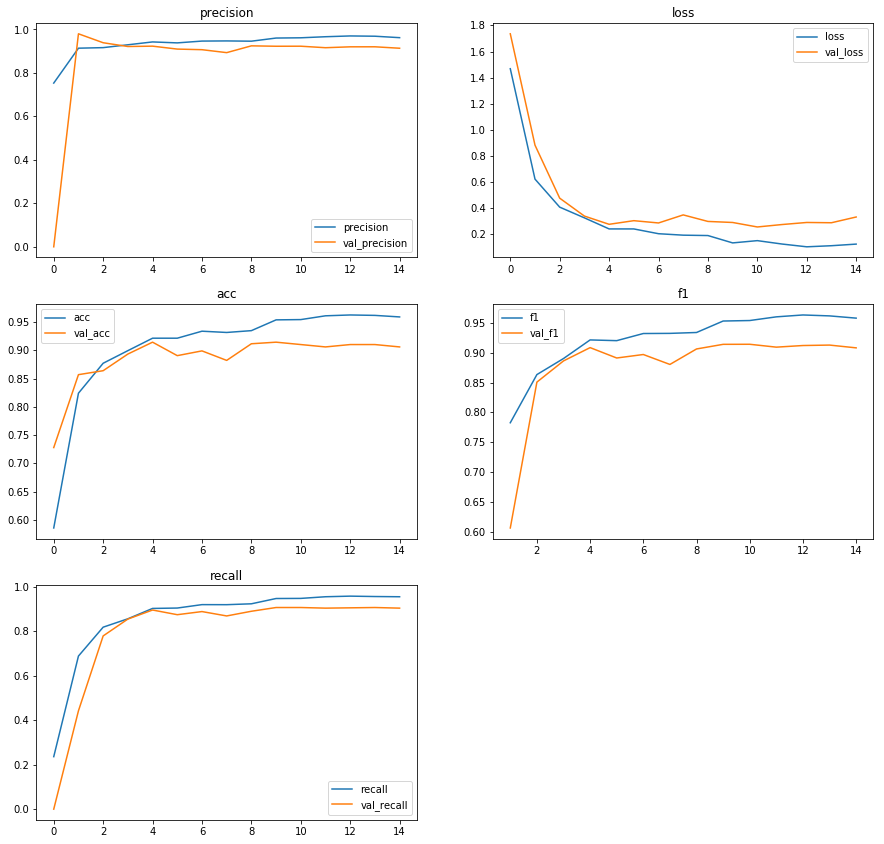

In [8]:
def plot_model(model):
    plots = [i for i in model.model.history.history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(15,25))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(model.model.history.history[p], label=p)
        plt.plot(model.model.history.history['val_'+p], label='val_'+p)
        plt.legend()

    plt.show()
    
plot_model(model)

In [6]:
from keras.models import load_model

best_model = load_model('models/CNN_Model.h5', custom_objects={'recall': recall, 'precision': precision, 'f1': f1})

score, acc, recall, precision, f1 = best_model.evaluate(X_val, y_val, batch_size=64)

idx = len(results) + 1
results.loc[idx] = ['CNN', acc, precision, recall, f1]

results

 64/713 [=>............................] - ETA: 0s

256/713 [=========>....................] - ETA: 0s

448/713 [=================>............] - ETA: 0s

576/713 [=======================>......] - ETA: 0s

704/713 [============================>.] - ETA: 0s

,Model,Accuracy,Precision,Recall,F1
1,CNN,0.910238,0.920129,0.904628,0.912277


Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = 300
max_depth = 50

reshaped_x_train = X_train.reshape(X_train.shape[0], -1)

rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
rf_model.fit(reshaped_x_train, y_train.argmax(1))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [8]:
from sklearn.externals import joblib

joblib.dump(rf_model, "models/RF_Model.h5")

['models/RF_Model.h5']

In [9]:
from sklearn import metrics

reshaped_x_val = X_val.reshape(X_val.shape[0], -1)

rf_model = joblib.load("models/RF_Model.h5")
rf_preds = rf_model.predict(reshaped_x_val)

idx = len(results) + 1
results.loc[idx] = ['Random Forests',
                       metrics.accuracy_score(y_val.argmax(1), rf_preds),
                       metrics.precision_score(y_val.argmax(1), rf_preds, average="macro"),
                       metrics.recall_score(y_val.argmax(1), rf_preds, average="macro"),
                       metrics.f1_score(y_val.argmax(1), rf_preds, average="macro") ]

results

,Model,Accuracy,Precision,Recall,F1
1,CNN,0.910238,0.920129,0.904628,0.912277
2,Random Forests,0.849930,0.862185,0.812205,0.824514
